# Thesis Sub-Benchmark (SB) Runner
# Minimal, self-contained execution notebook.
# - Uses pipeline modules in /mnt/data (main.py, runner.py, evaluator.py, viz_samples.py)
# - Saves results under results/<timestamp>_<EXP_NAME>/
# - Shows the generated figures inline and prints tables for quick troubleshooting.
#
# Tip: Lower N_SEEDS first for quick smoke tests, then scale up to 40 seeds.


## SB1 — DOE head-to-head on Branin-2D
Noise α∈{0, 0.20, 0.50}. T chosen near CCD size; here we use T=10 (face-centered CCD has 9 base points -> 1 LHS top-up). Seeds default to 40.

In [ ]:
# import importlib, evaluator
# importlib.reload(evaluator)
# print(evaluator.__file__)  # sollte auf deinen Projektpfad zeigen

# import importlib, main
# importlib.reload(main)
# print("BUDGETS:", getattr(main, "BUDGETS", None))
# print("BUDGET_FACTORS:", getattr(main, "BUDGET_FACTORS", None))

# import sys, importlib, main
# print("MAIN FILE:", main.__file__)

# from evaluator import export_auc_table_from_agg

In [1]:
import os, sys, time, json, glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image, Markdown, HTML

# Ensure local modules are importable
ROOT = Path("/mnt/data").resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import main  # uses /mnt/data/main.py
from evaluator import (
    load_logs, aggregate_regret, plot_regret_curves, add_normalized_regret,
    aggregate_regret_norm, plot_regret_norm_curves, plot_box_regret_at_T,
    plot_box_regret_norm_at_T, plot_box_best_value_at_T, plot_ybest_curves,
    rank_by_group, winrate_by_group, plot_rank_heatmap, plot_winrate_heatmap,
    save_rank_tables, save_tables, export_best_at_T_table,
    save_best_at_T_tables_as_png, render_boxplot_side_tables, export_auc_table_from_agg
)  # uses /mnt/data/evaluator.py

def find_latest_results(exp_name: str) -> Path:
    root = Path("results")
    if not root.exists():
        raise FileNotFoundError("No results/ folder yet.")
    cands = [p for p in root.glob(f"*_{exp_name}") if p.is_dir()]
    if not cands:
        # fallback: any folder containing exp_name
        cands = [p for p in root.glob("*_*") if exp_name in p.name]
    if not cands:
        raise FileNotFoundError(f"No results subfolder matching: {exp_name}")
    return max(cands, key=lambda p: p.stat().st_mtime)

def show_pngs(paths, width=820):
    for p in paths:
        p = Path(p)
        if p.exists():
            display(Image(filename=str(p), width=width))

def show_all_core_plots(outdir: Path):
    # Display the plots main.py already created when PLOT_IN_MAIN=True
    plots = outdir / "plots"
    # groups = [
    #     "regret_curves", "regret_curves_obs", "regret_norm_curves",
    #     "regret", "regret_obs", "regret_norm", "best_value", "heatmaps"
    # ]
    groups = [
        "regret_curves", "regret_norm_curves",
        "regret", "regret_norm", "best_value", "heatmaps"
    ]
    all_imgs = []
    for g in groups:
        d = plots / g
        if d.exists():
            all_imgs += sorted(d.glob("*.png"))
    if all_imgs:
        print(f"Showing {len(all_imgs)} plot images ...")
        show_pngs(all_imgs)

    # Also show the small per-boxplot side tables (PNG) if present
    table_pngs = sorted((outdir/"plots").rglob("*_table.png"))
    if table_pngs:
        print(f"Showing {len(table_pngs)} boxplot side-table PNGs ...")
        show_pngs(table_pngs, width=640)

    # And global 'best_at_T' PNG tables
    global_tables = sorted((outdir/"tables").glob("best_at_T_*.png"))
    if global_tables:
        print("Global Best@T tables:")
        show_pngs(global_tables, width=720)

def show_core_dataframes(outdir: Path):
    # Load unified logs
    df = load_logs(outdir)
    print("all_runs.csv shape:", df.shape)
    # Final rows per run for boxplots
    keys = ["problem","method","seed","budget"]
    if "noise_pct" in df.columns:
        keys.append("noise_pct")
    dff = df.sort_values("iter").groupby(keys, as_index=False).tail(1)
    display(Markdown("**Final rows per run (for boxplots):**"))
    display(dff.head(20))

    # Aggregates for curves (true & observed regret)
    agg_true = aggregate_regret(df, use_observed=False)
    display(Markdown("**Aggregate (true regret) for curves:**"))
    display(agg_true.head(20))
    # agg_obs = aggregate_regret(df, use_observed=True)
    # display(Markdown("**Aggregate (observed regret) for curves:**"))
    # display(agg_obs.head(20))

    # Normalized regret
    dfn = add_normalized_regret(df.copy())
    if "regret_norm" in dfn.columns:
        aggn = aggregate_regret_norm(dfn)
        display(Markdown("**Aggregate (normalized regret) for curves:**"))
        display(aggn.head(20))

def run_and_collect(exp_name: str):
    # main.main() uses current module-level config values set below.
    print("Launching main.main() ...")
    main.main()
    outdir = find_latest_results(exp_name)

    # Recompute aggregates and export AUC tables
    from evaluator import aggregate_regret, aggregate_regret_norm, add_normalized_regret, export_auc_table_from_agg
    df_all = load_logs(outdir)

    agg_true = aggregate_regret(df_all, use_observed=False)
    export_auc_table_from_agg(agg_true, outdir, label="true")

    # agg_obs = aggregate_regret(df_all, use_observed=True)
    # export_auc_table_from_agg(agg_obs, outdir, label="obs")

    dfn = add_normalized_regret(df_all.copy())
    if "regret_norm" in dfn.columns:
        aggn = aggregate_regret_norm(dfn)
        export_auc_table_from_agg(aggn, outdir, label="norm")

    print("Artifacts written to:", outdir)
    # Ensure all table PNGs exist (best@T + per-boxplot)
    try:
        save_best_at_T_tables_as_png(outdir, decimals=3)
    except Exception as e:
        print("[warn] save_best_at_T_tables_as_png:", e)
    try:
        render_boxplot_side_tables(outdir, decimals=3)
    except Exception as e:
        print("[warn] render_boxplot_side_tables:", e)
    return outdir


In [ ]:
# NOW set your experiment config:
main.EXP_NAME = "SB1_DOE_Head2Head"
main.PROBLEMS = ["Branin"]
main.METHODS  = ["DOE_CCD","DOE_LHS","DOE_FF"]
main.BUDGETS  = [20]   # oder [50]
main.SEEDS    = list(range(40))
main.NOISE_PCTS = [0.0, 0.20, 0.50]
main.INIT_FACTOR = 2.0
main.PLOT_IN_MAIN = True

# Nur ein Sample pro Run am Ende bei T
main.GENERATE_SAMPLES   = True          # Samples überhaupt erzeugen
main.FINAL_SAMPLES_AT_T = True          # erzwingt final-only
main.K_EVERY            = 1             # wird bei FINAL_SAMPLES_AT_T=True intern ignoriert

print("BUDGETS:", getattr(main, "BUDGETS", None))

BUDGETS: [20]
BUDGET_FACTORS: None


Launching main.main() ...
[run] Branin | DOE_CCD | seed=0 | T=20 | noise=0.00
[run] Branin | DOE_CCD | seed=0 | T=20 | noise=0.20
[run] Branin | DOE_CCD | seed=0 | T=20 | noise=0.50
[run] Branin | DOE_CCD | seed=1 | T=20 | noise=0.00
[run] Branin | DOE_CCD | seed=1 | T=20 | noise=0.20
[run] Branin | DOE_CCD | seed=1 | T=20 | noise=0.50
[run] Branin | DOE_CCD | seed=2 | T=20 | noise=0.00
[run] Branin | DOE_CCD | seed=2 | T=20 | noise=0.20
[run] Branin | DOE_CCD | seed=2 | T=20 | noise=0.50
[run] Branin | DOE_CCD | seed=3 | T=20 | noise=0.00
[run] Branin | DOE_CCD | seed=3 | T=20 | noise=0.20
[run] Branin | DOE_CCD | seed=3 | T=20 | noise=0.50
[run] Branin | DOE_CCD | seed=4 | T=20 | noise=0.00
[run] Branin | DOE_CCD | seed=4 | T=20 | noise=0.20
[run] Branin | DOE_CCD | seed=4 | T=20 | noise=0.50
[run] Branin | DOE_CCD | seed=5 | T=20 | noise=0.00
[run] Branin | DOE_CCD | seed=5 | T=20 | noise=0.20
[run] Branin | DOE_CCD | seed=5 | T=20 | noise=0.50
[run] Branin | DOE_CCD | seed=6 | T=20

c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:1043: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  plt.savefig(out / fname, dpi=150, bbox_inches="tight")
c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:2106: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:2106: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:2106: UserWarning: The figure layout has changed to tight
  fig.tight_

Table PNGs: {'true': 'results\\20251026_135323_SB1_DOE_Head2Head\\tables\\best_at_T_by_seed_method_true.png', 'obs': 'results\\20251026_135323_SB1_DOE_Head2Head\\tables\\best_at_T_by_seed_method_obs.png', 'norm': 'results\\20251026_135323_SB1_DOE_Head2Head\\tables\\best_at_T_by_seed_method_norm.png'}
[warn] render_boxplot_side_tables failed: name '_df_apply_elementwise' is not defined
Report: results\20251026_135323_SB1_DOE_Head2Head\benchmark_report.html
[debug] all_runs shape: (7200, 21), columns: ['best_so_far', 'best_so_far_obs', 'budget', 'dim', 'exp_name', 'init_factor', 'iter', 'method', 'noise_pct', 'noise_seed', 'problem', 'regret', 'regret_obs', 'seed', 'sigma_noise', 'time_s', 'x', 'x_uv', 'x_xy', 'y', 'y_noisy']
Artifacts written to: results\20251026_135323_SB1_DOE_Head2Head


c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:1889: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:1889: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Artifacts written to: results\20251026_135323_SB1_DOE_Head2Head


c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:2106: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:2106: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:2106: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


[warn] render_boxplot_side_tables: name '_df_apply_elementwise' is not defined
Showing 30 plot images ...


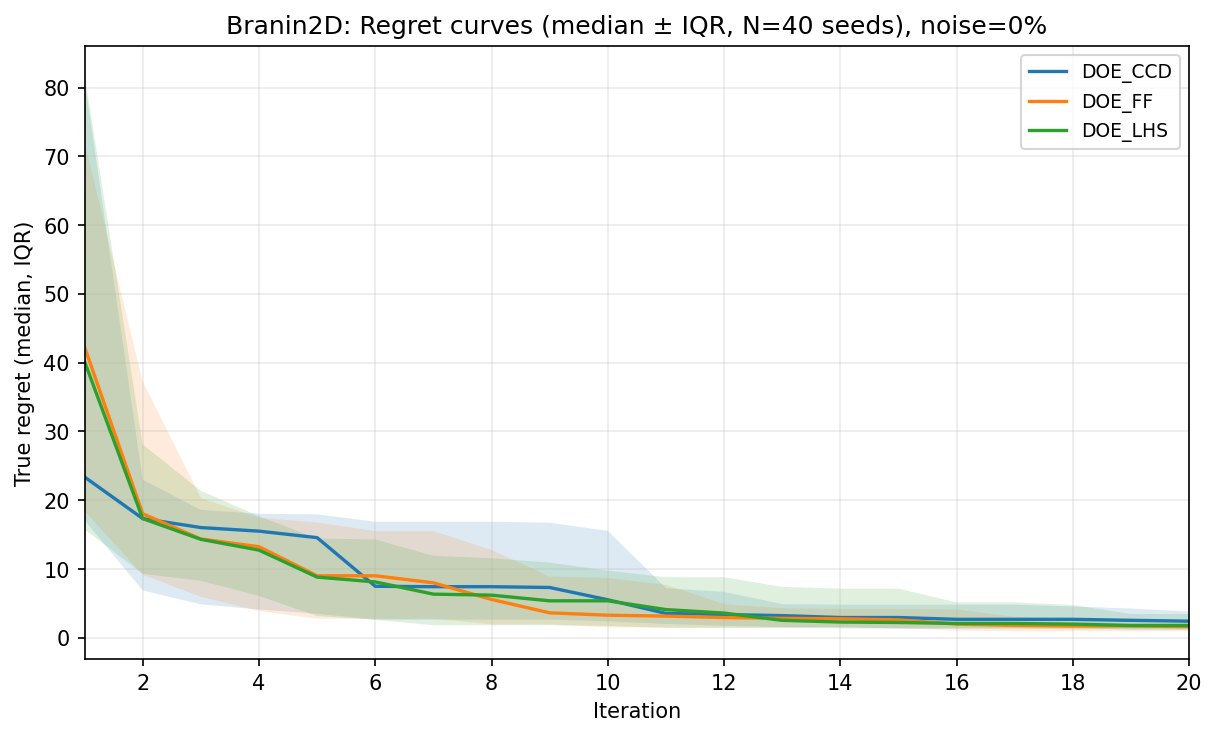

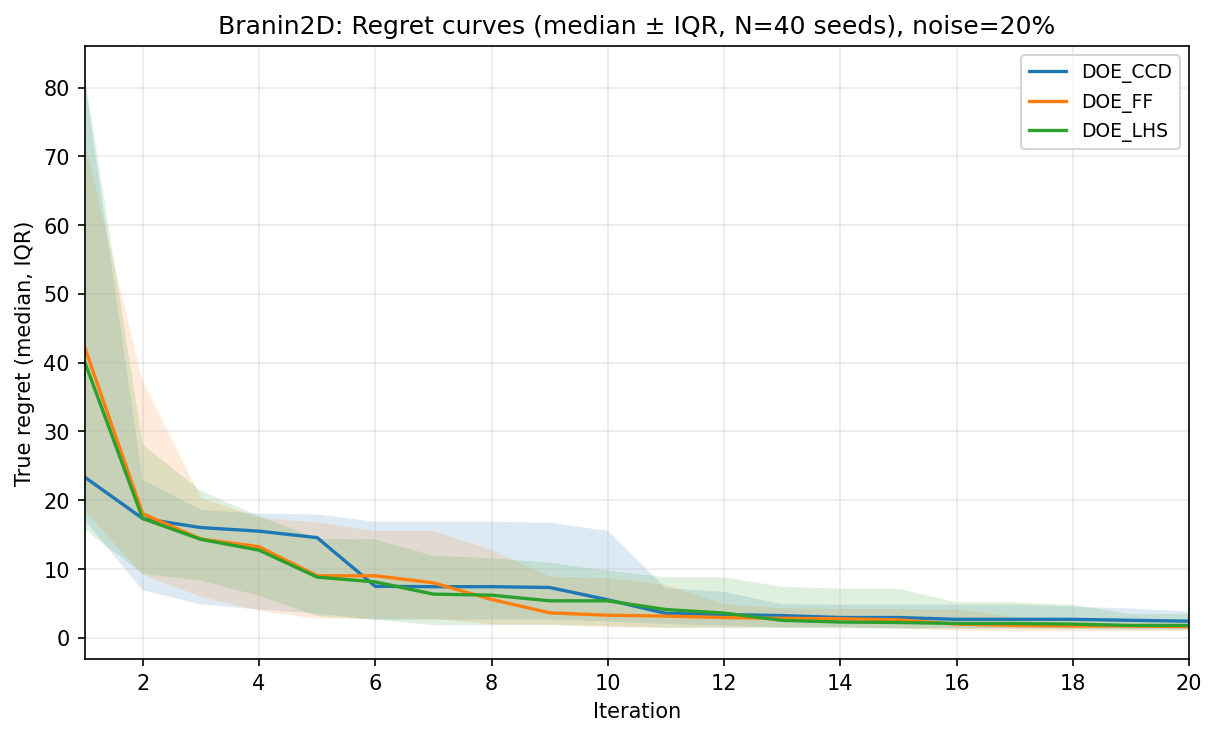

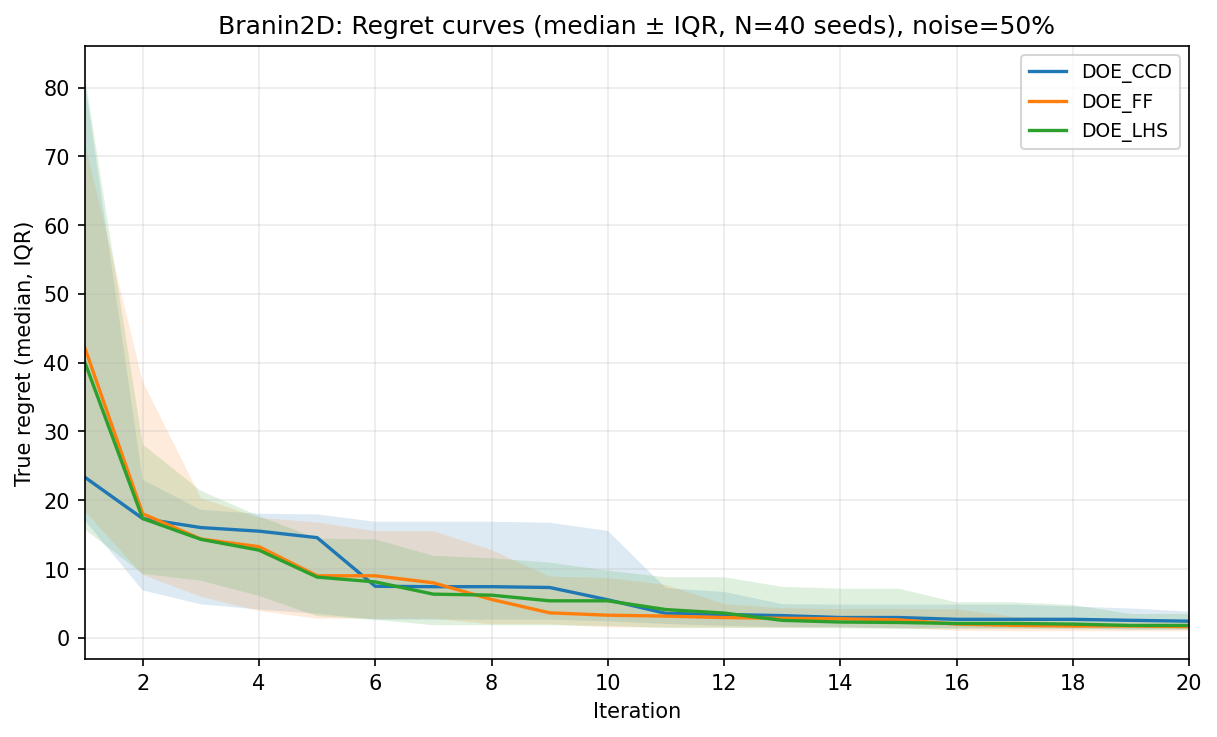

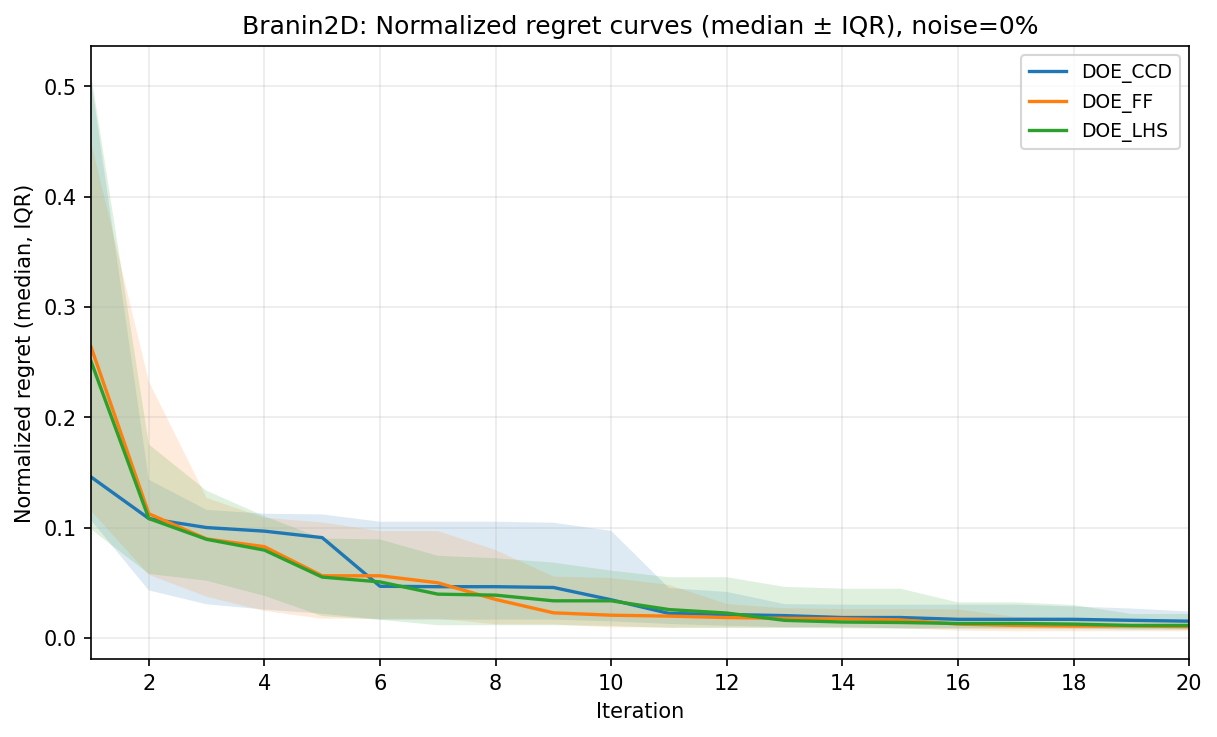

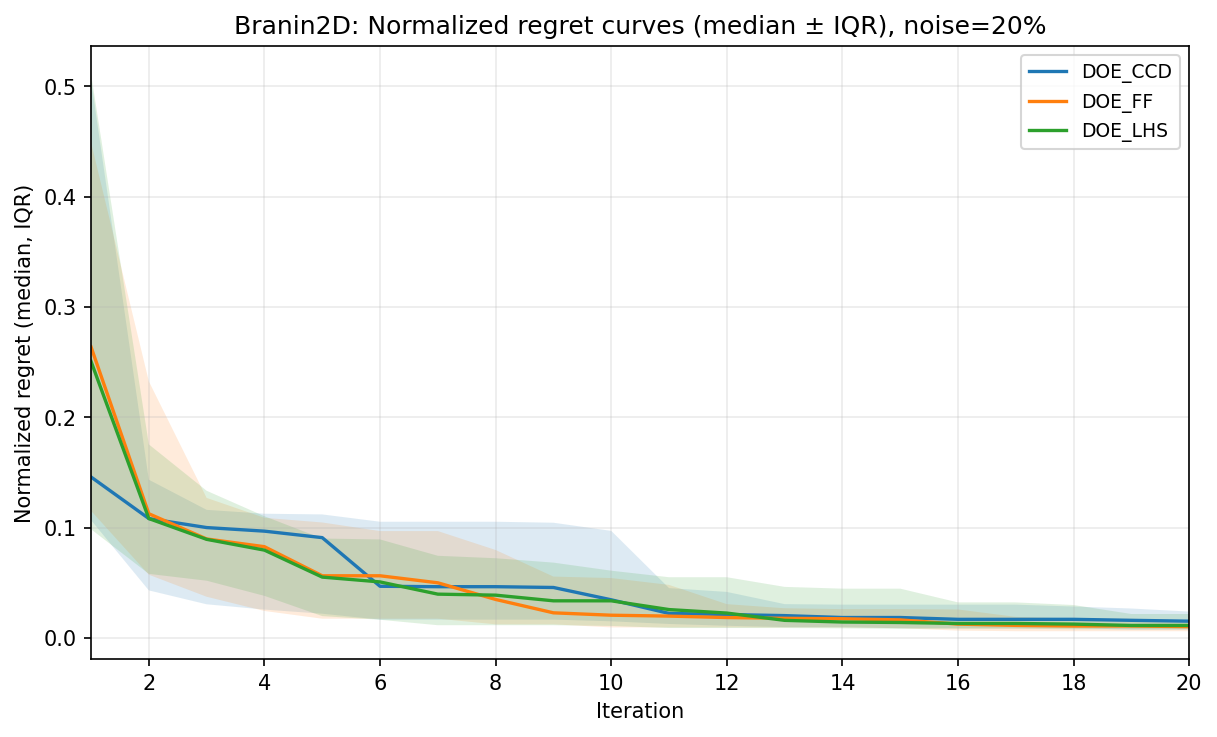

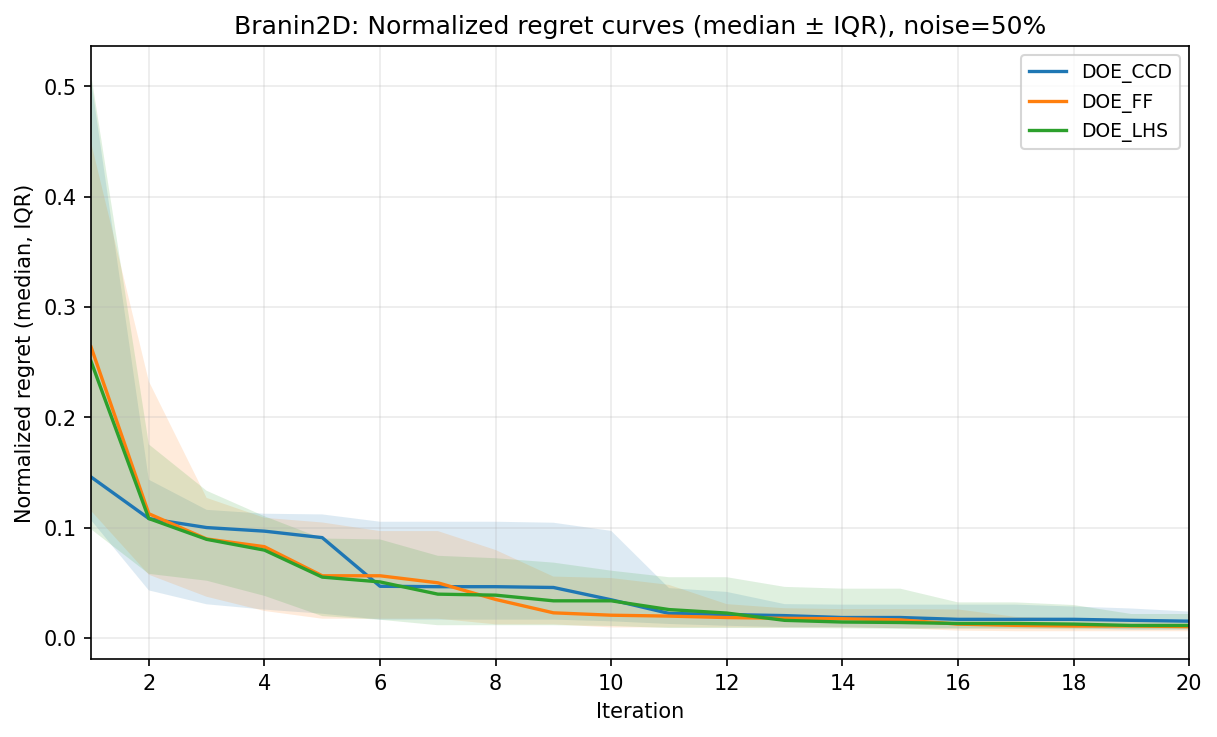

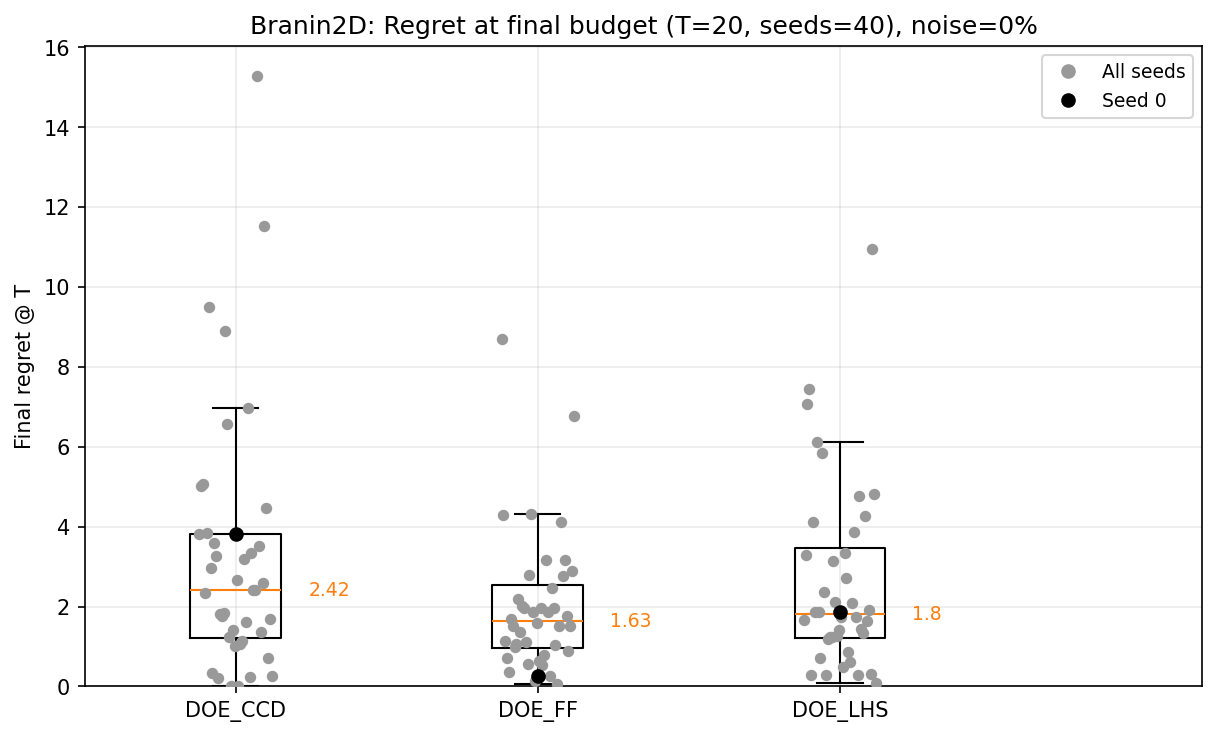

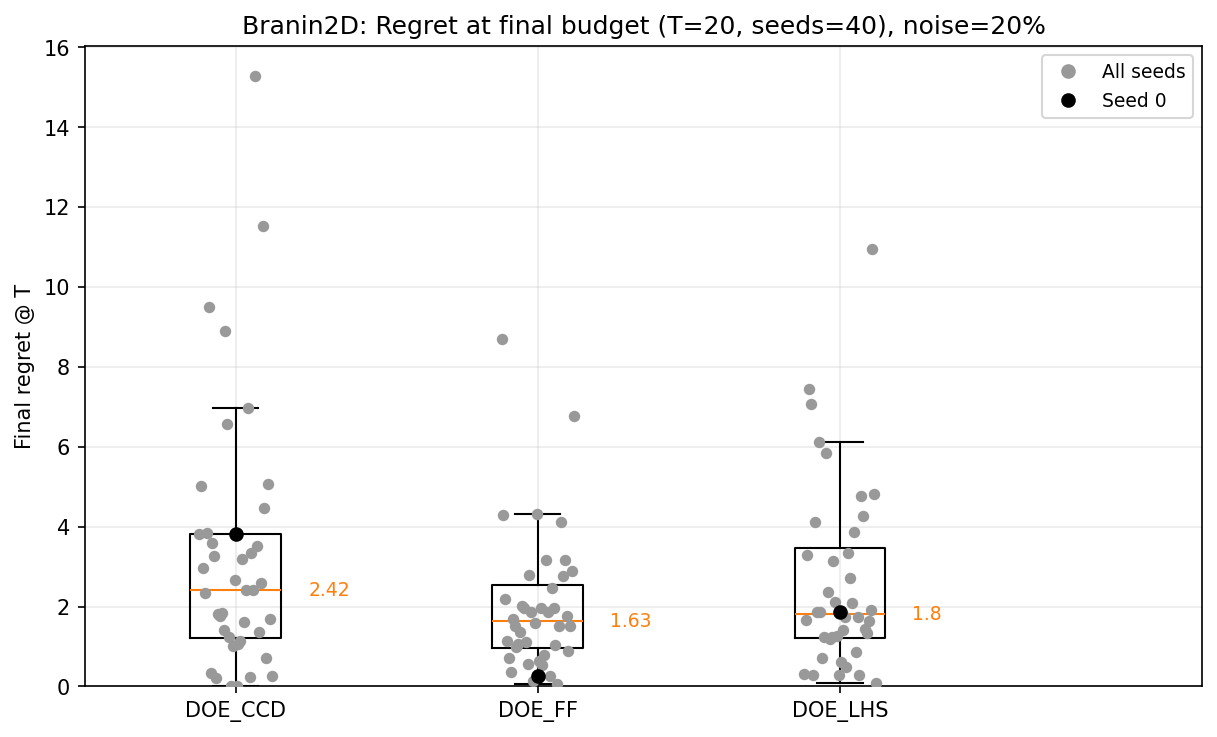

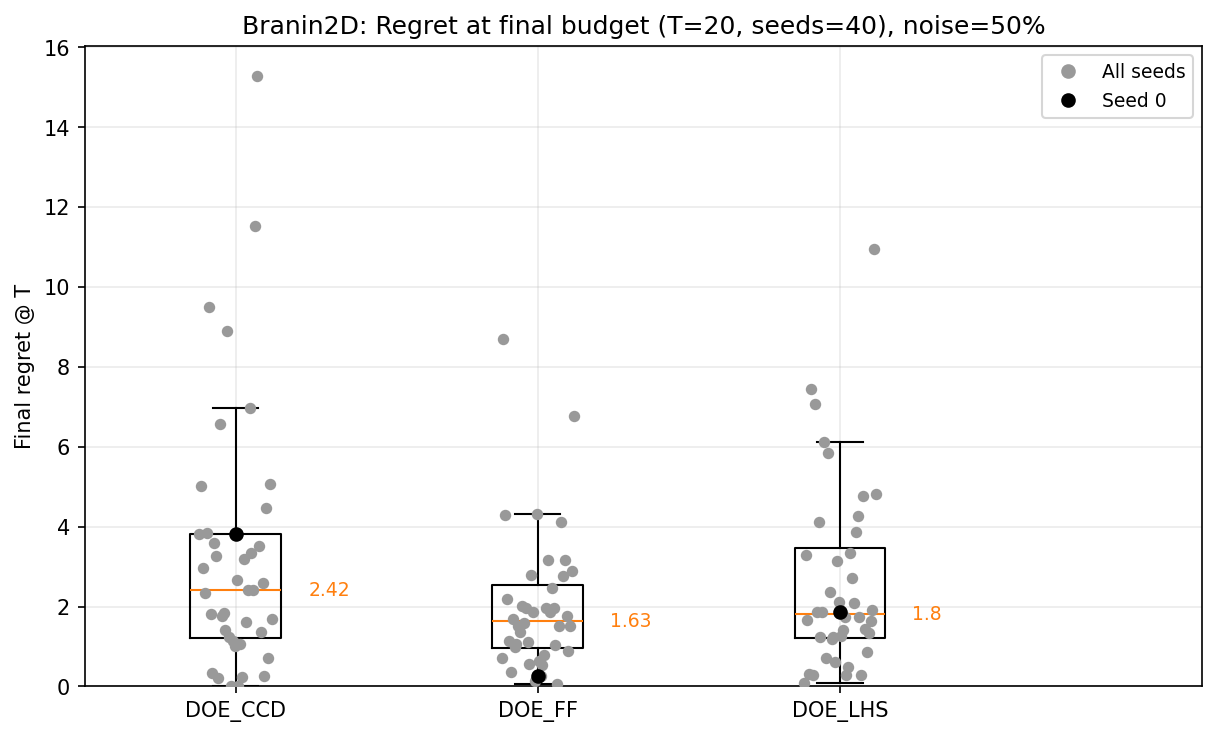

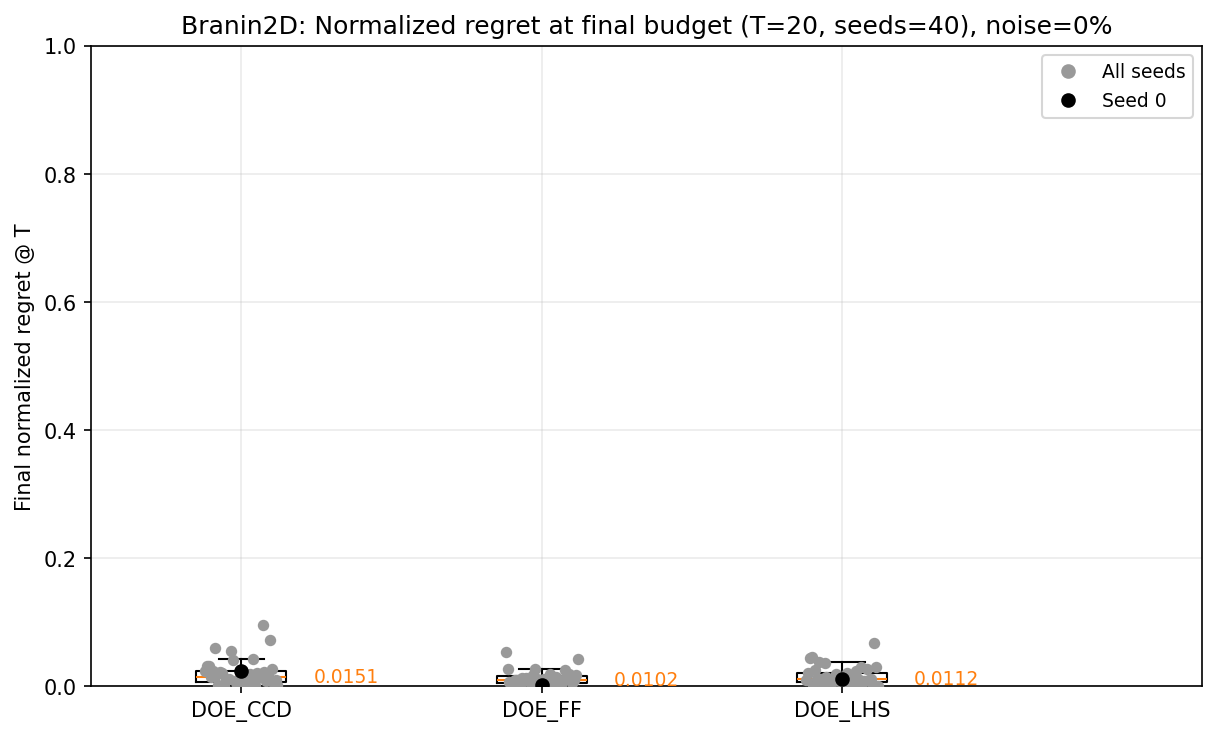

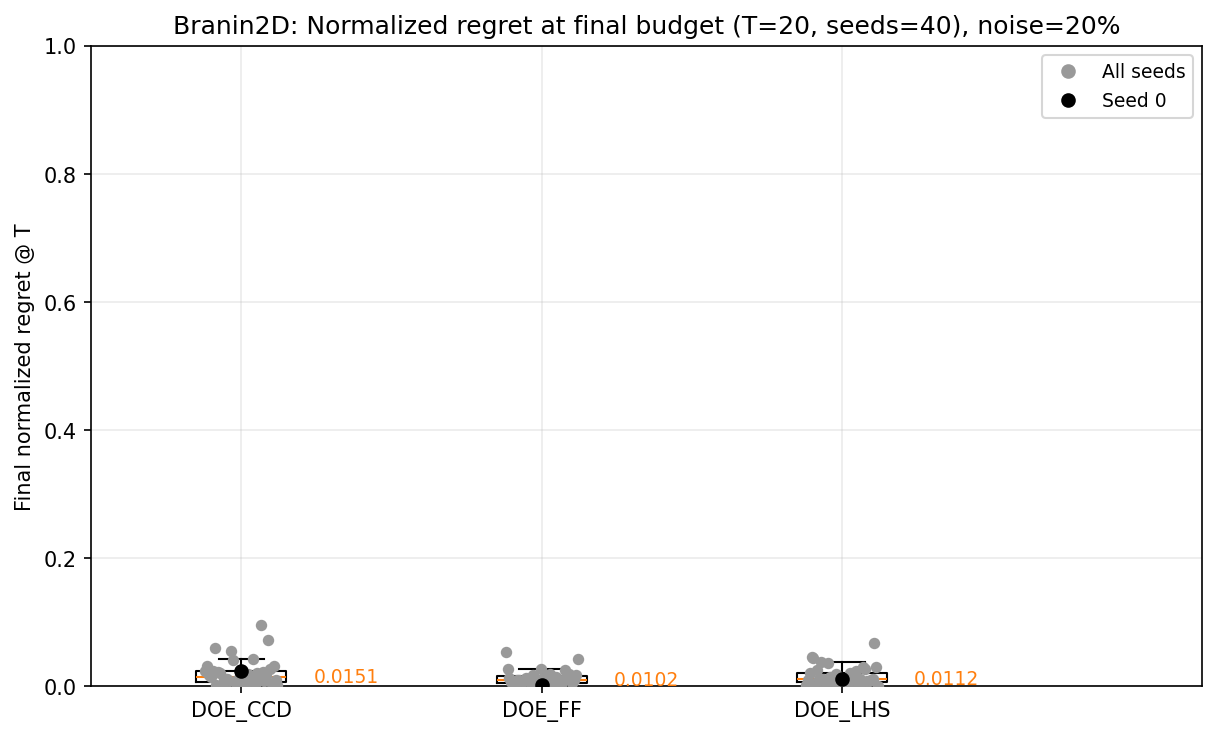

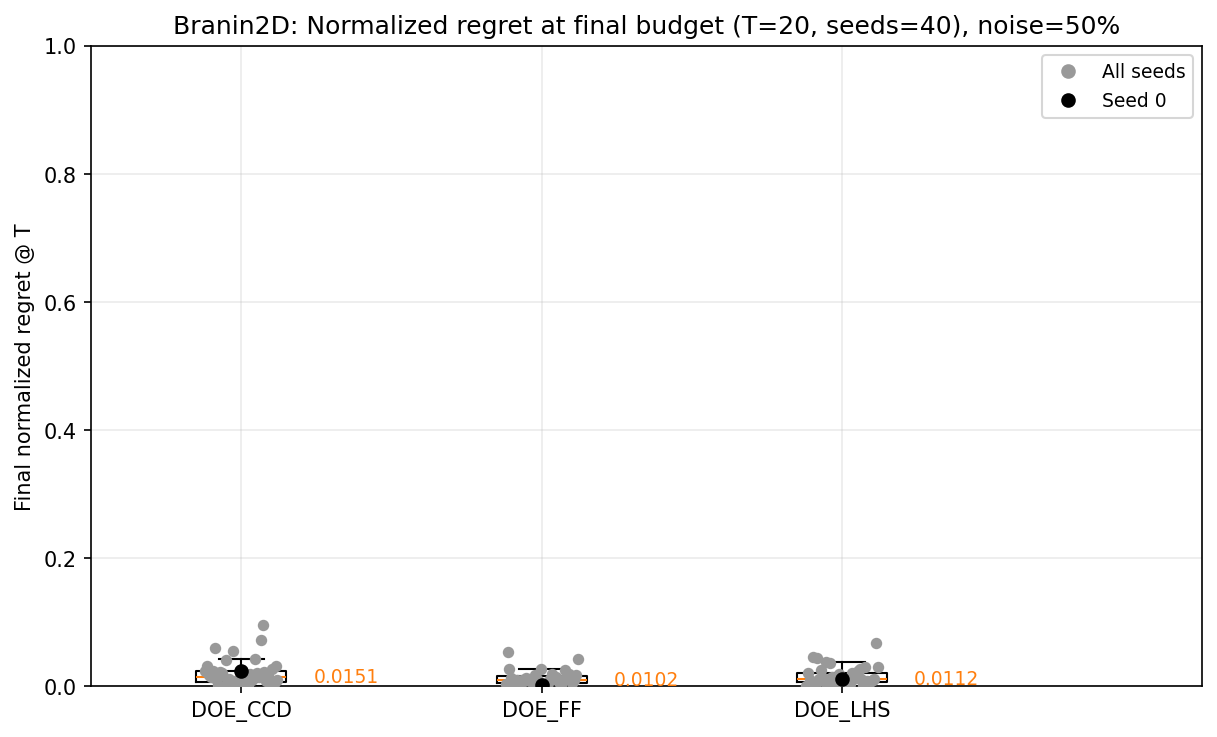

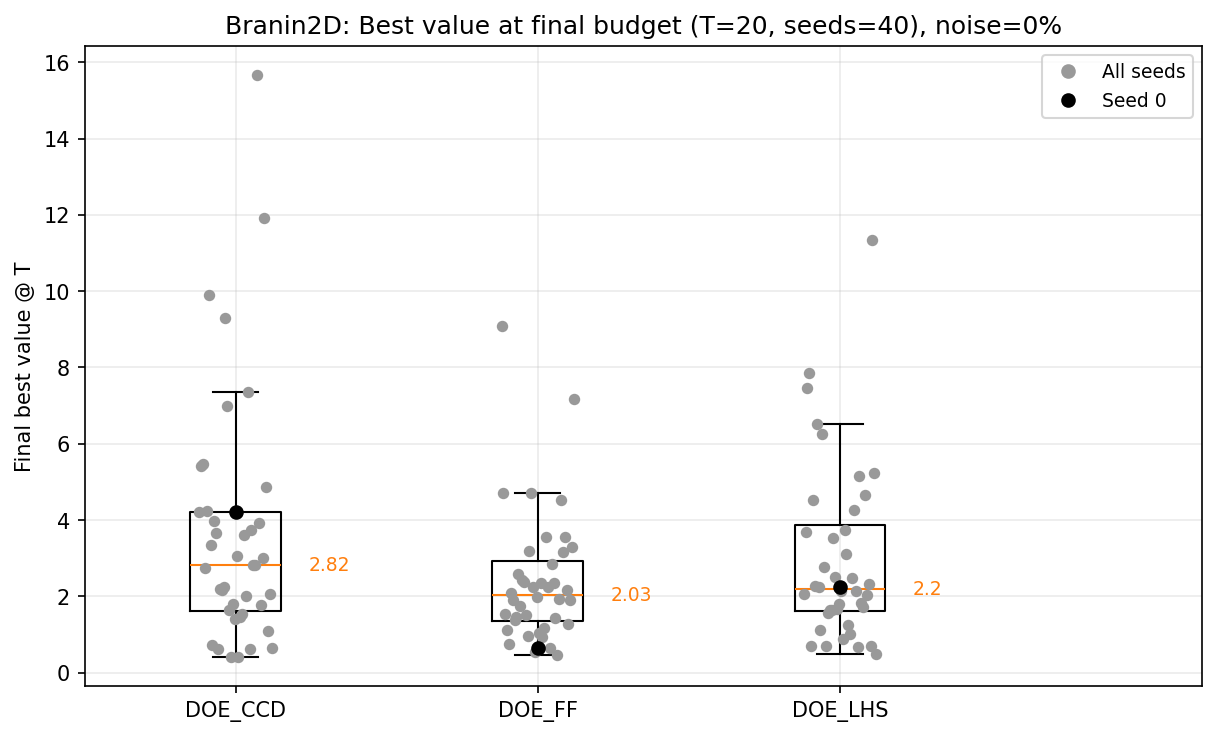

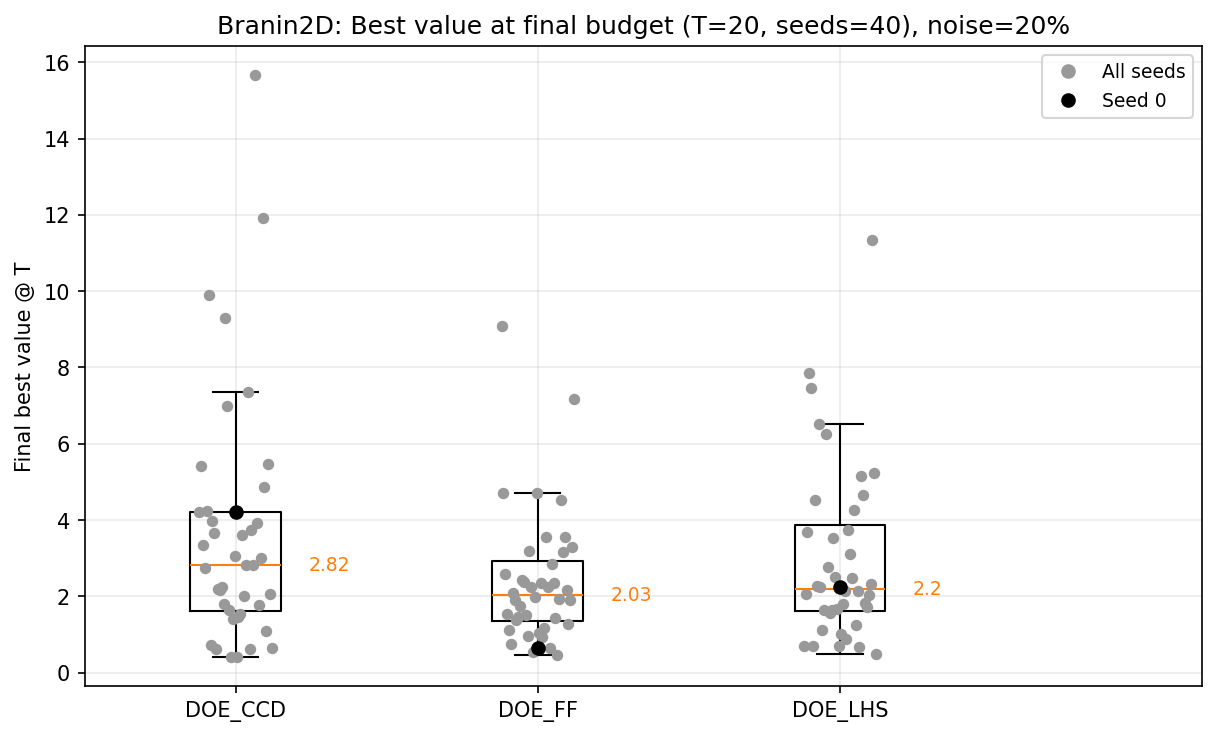

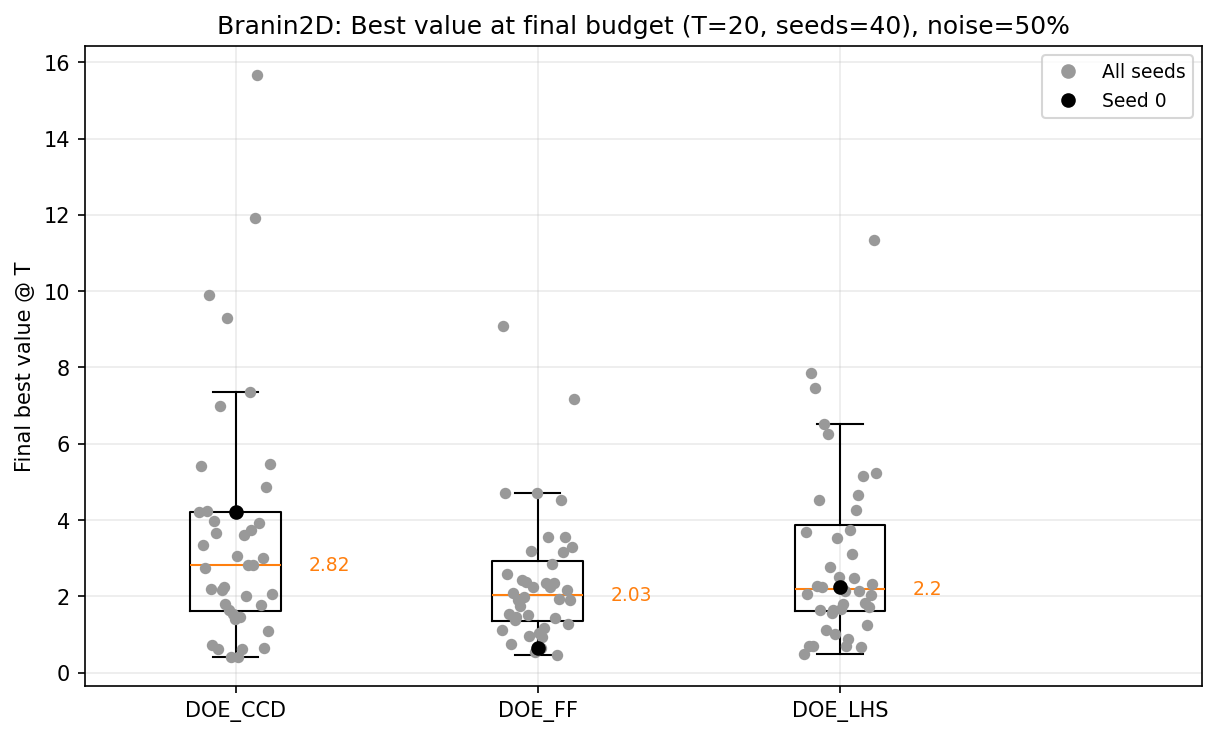

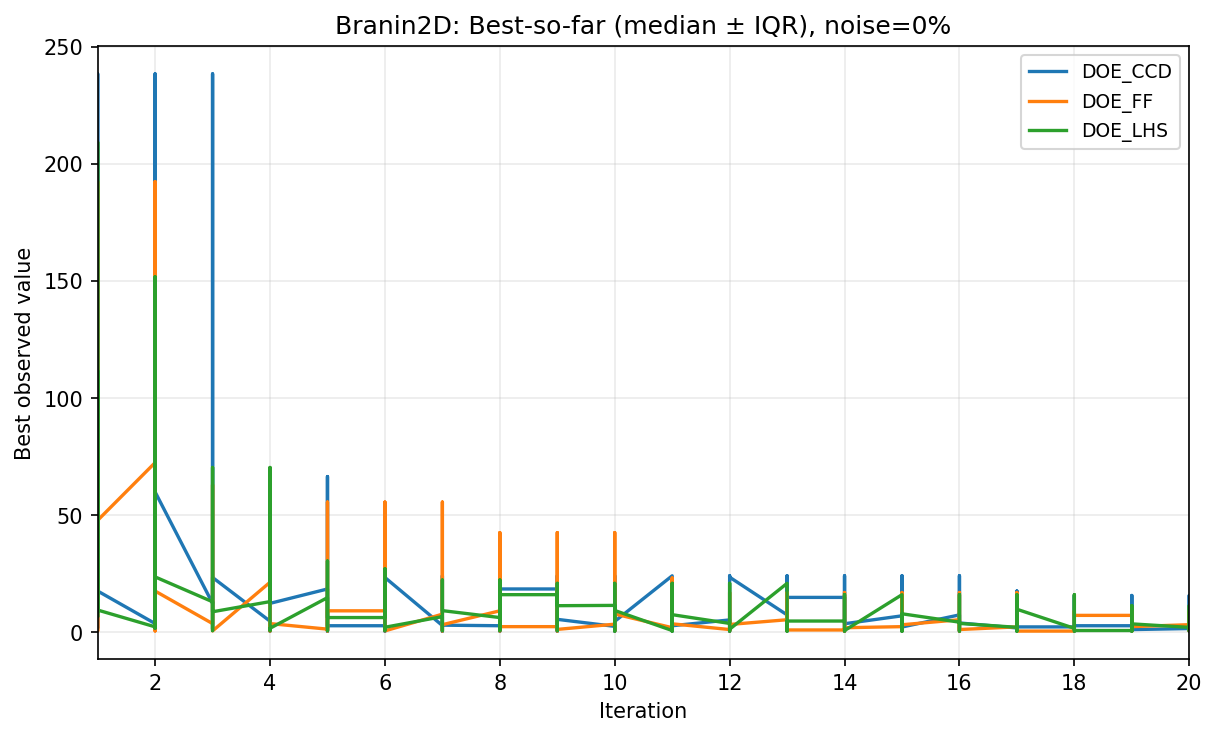

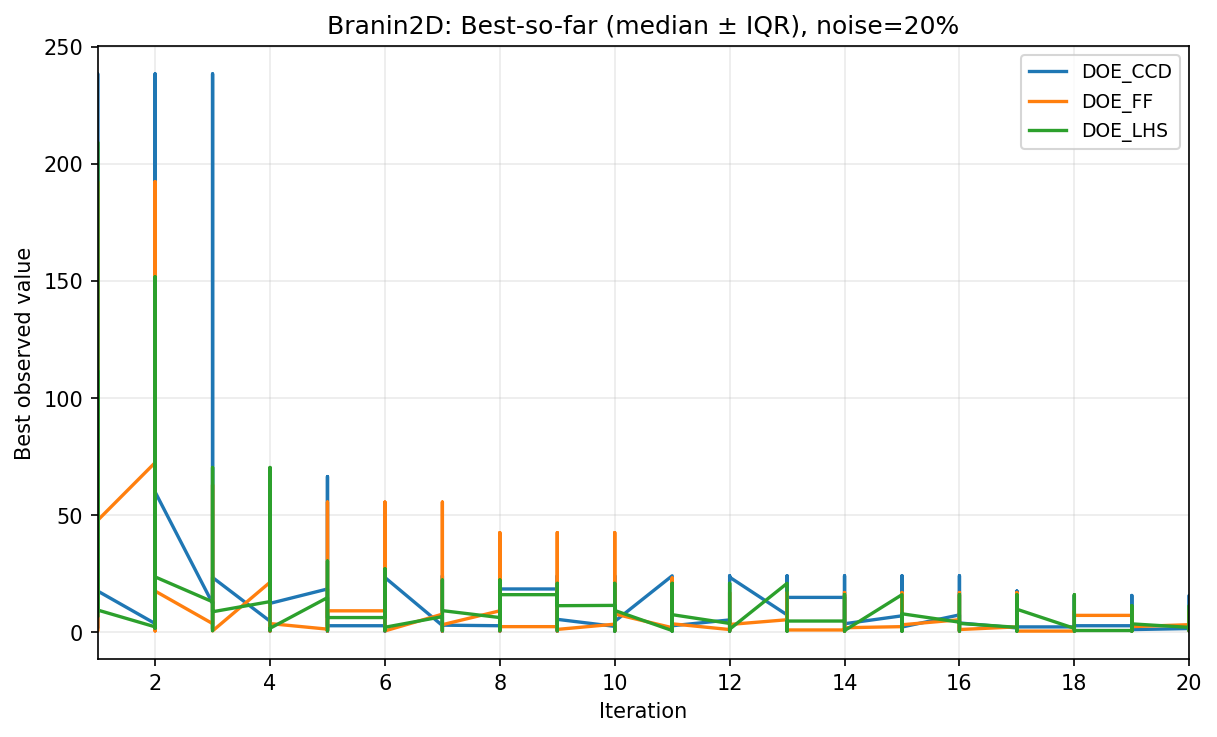

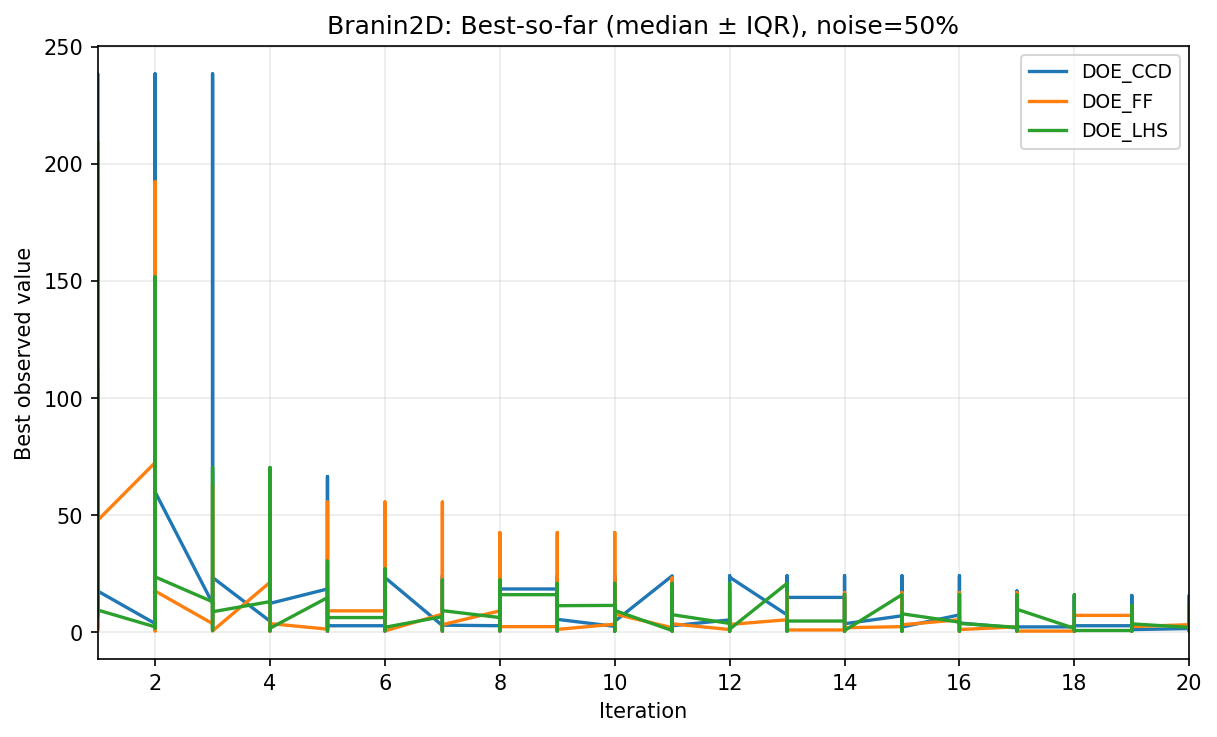

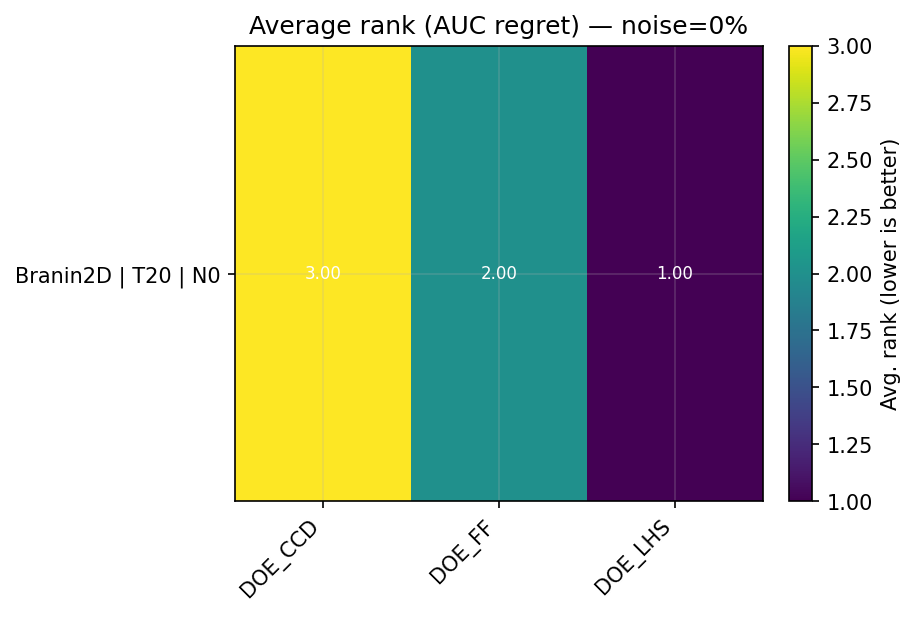

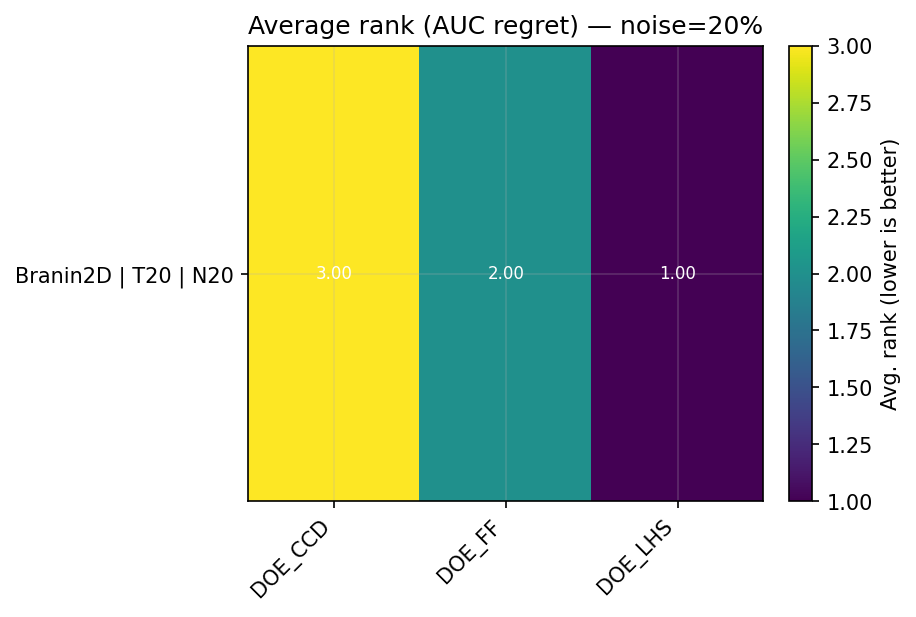

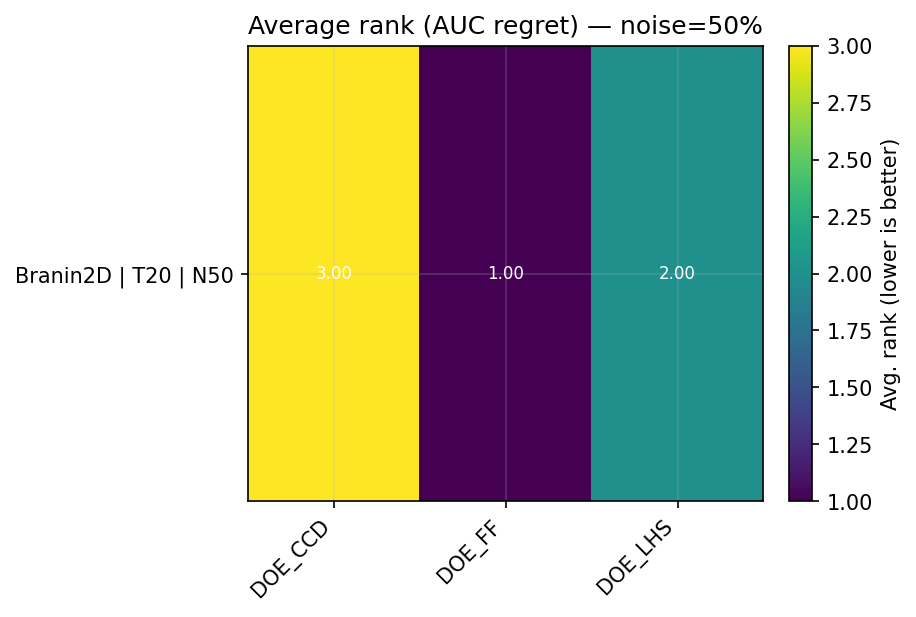

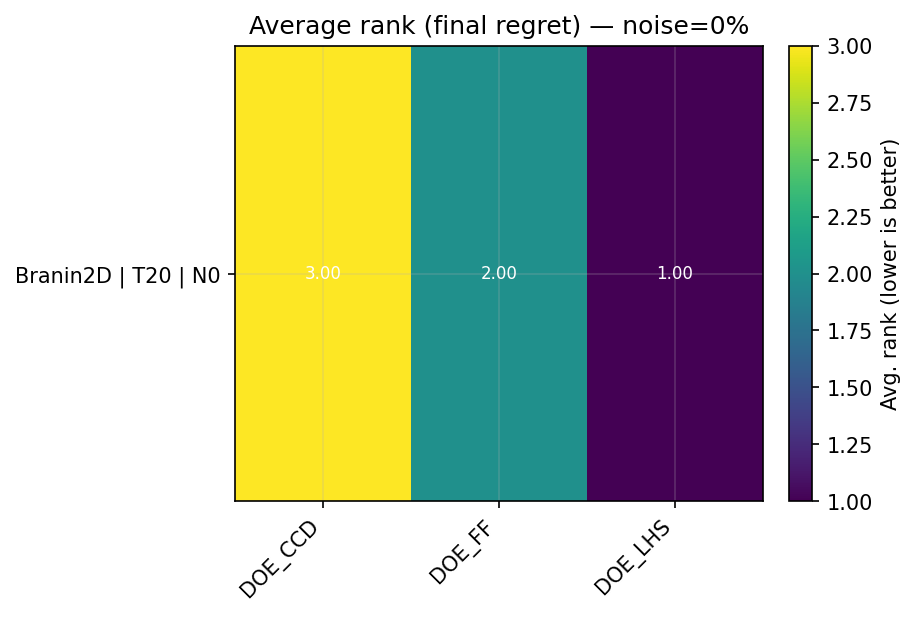

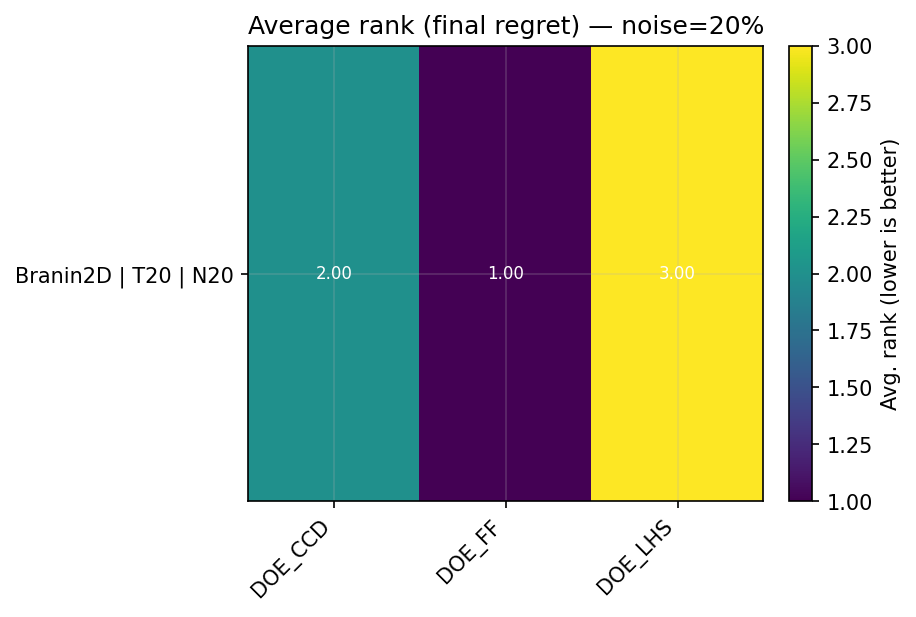

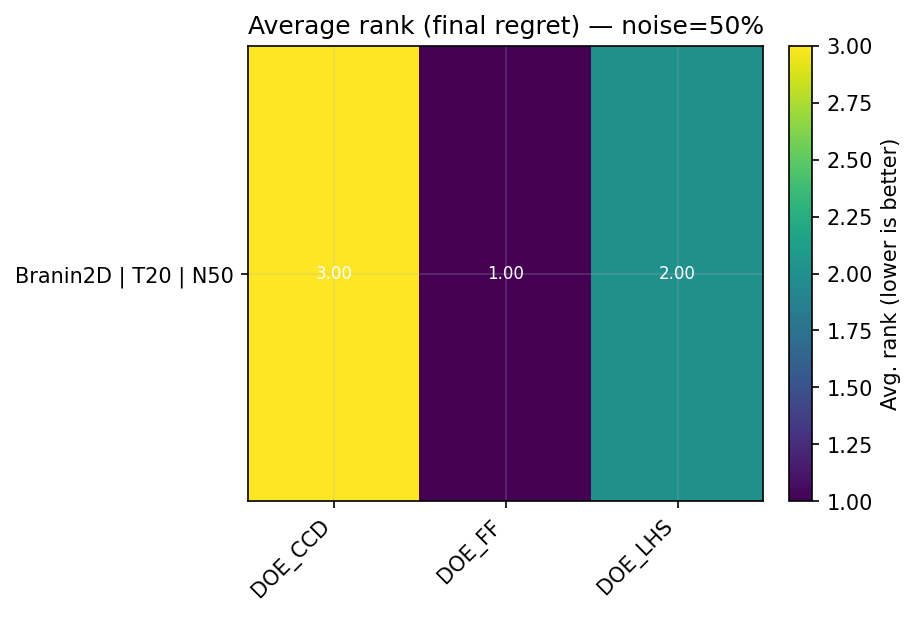

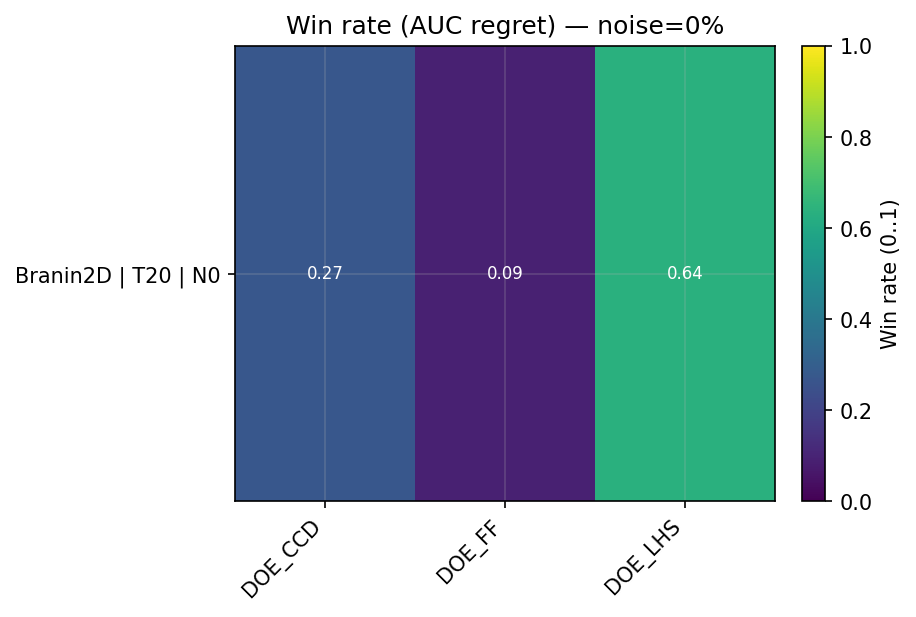

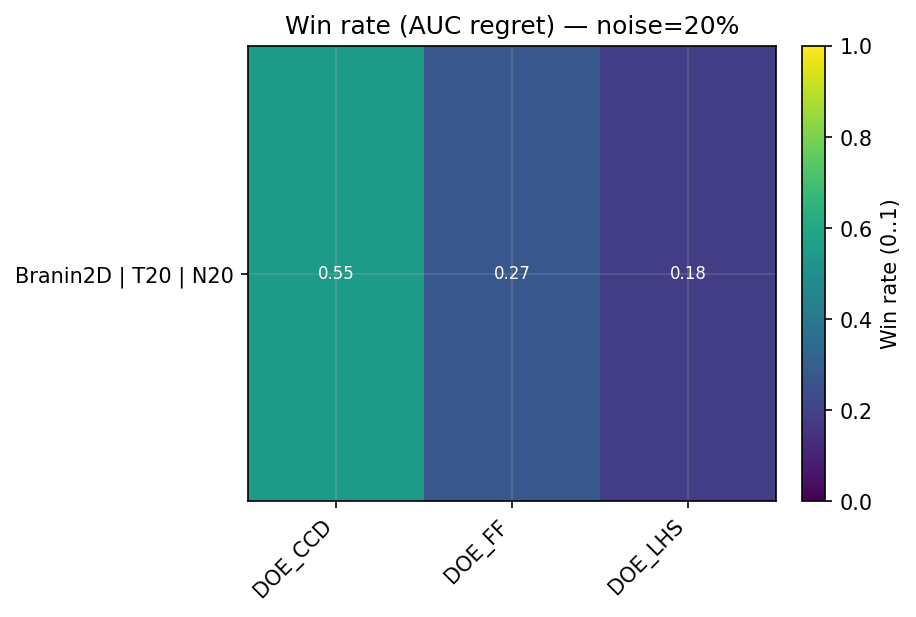

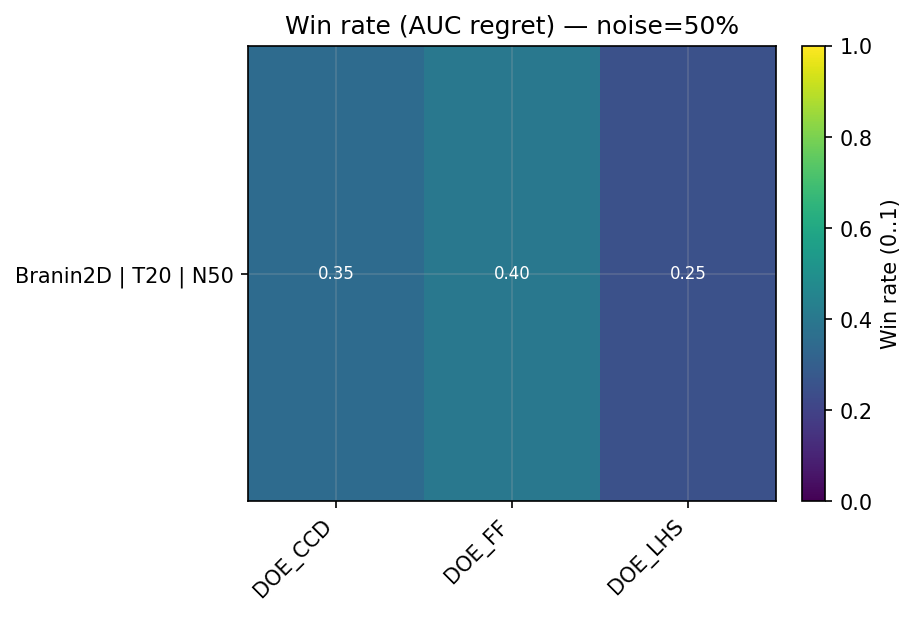

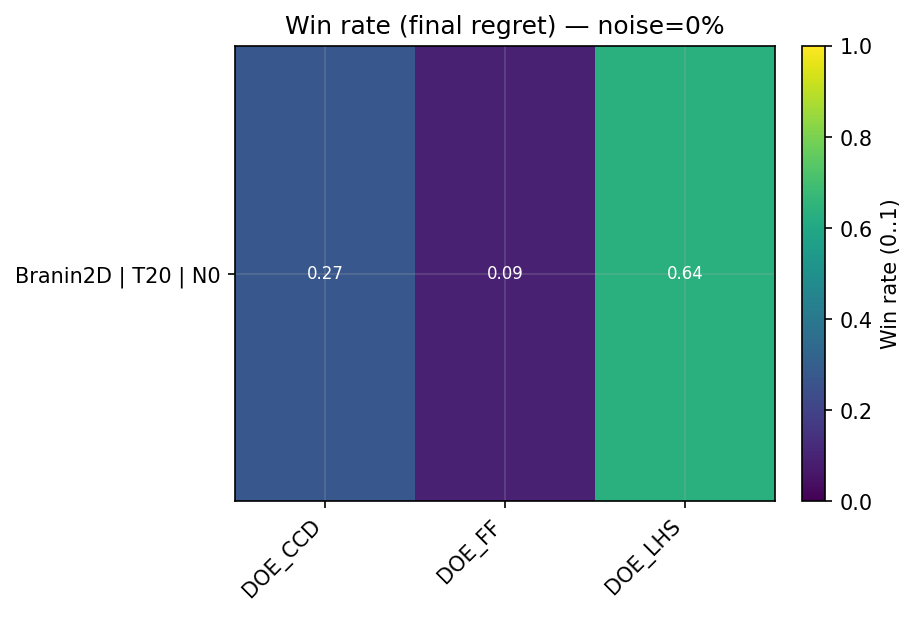

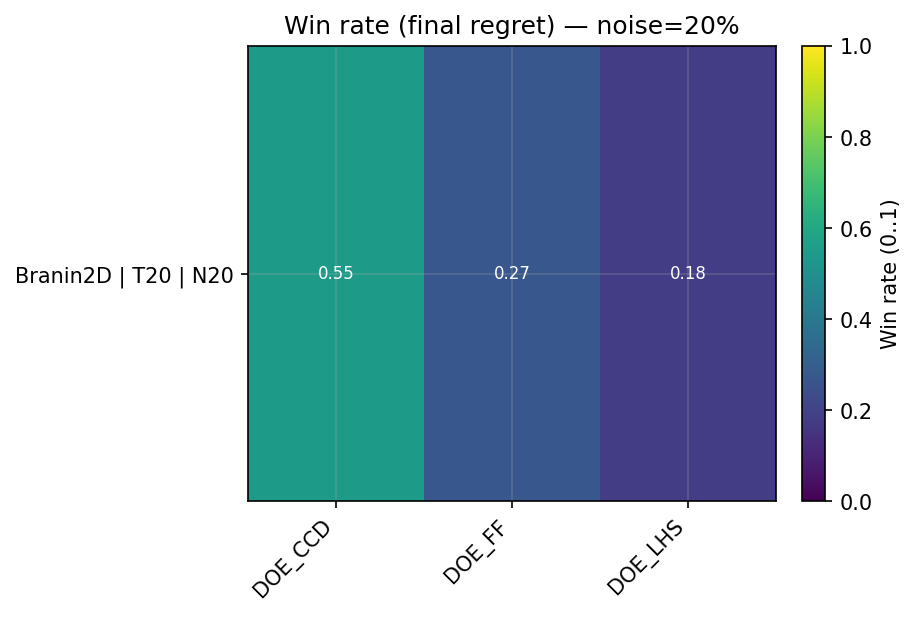

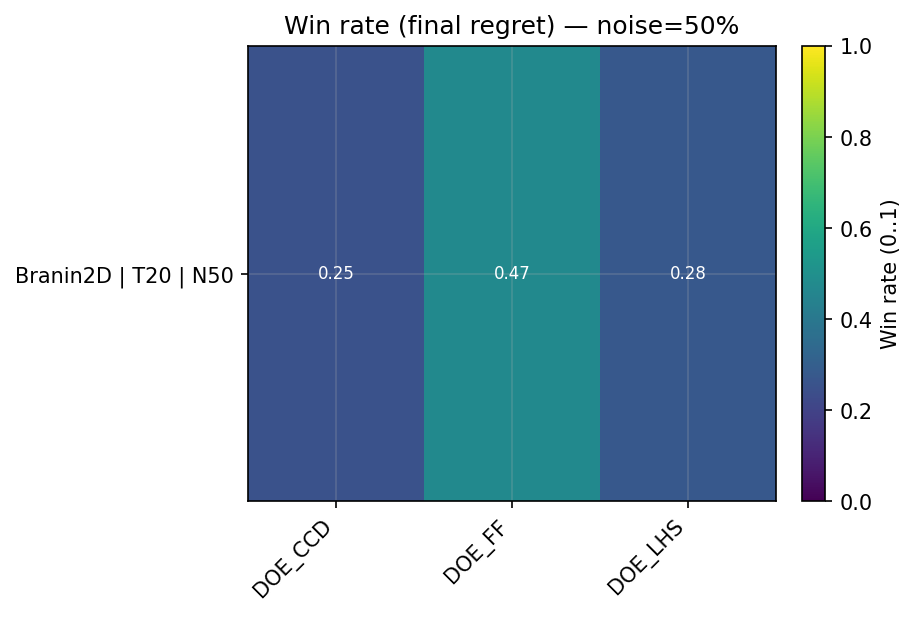

Global Best@T tables:


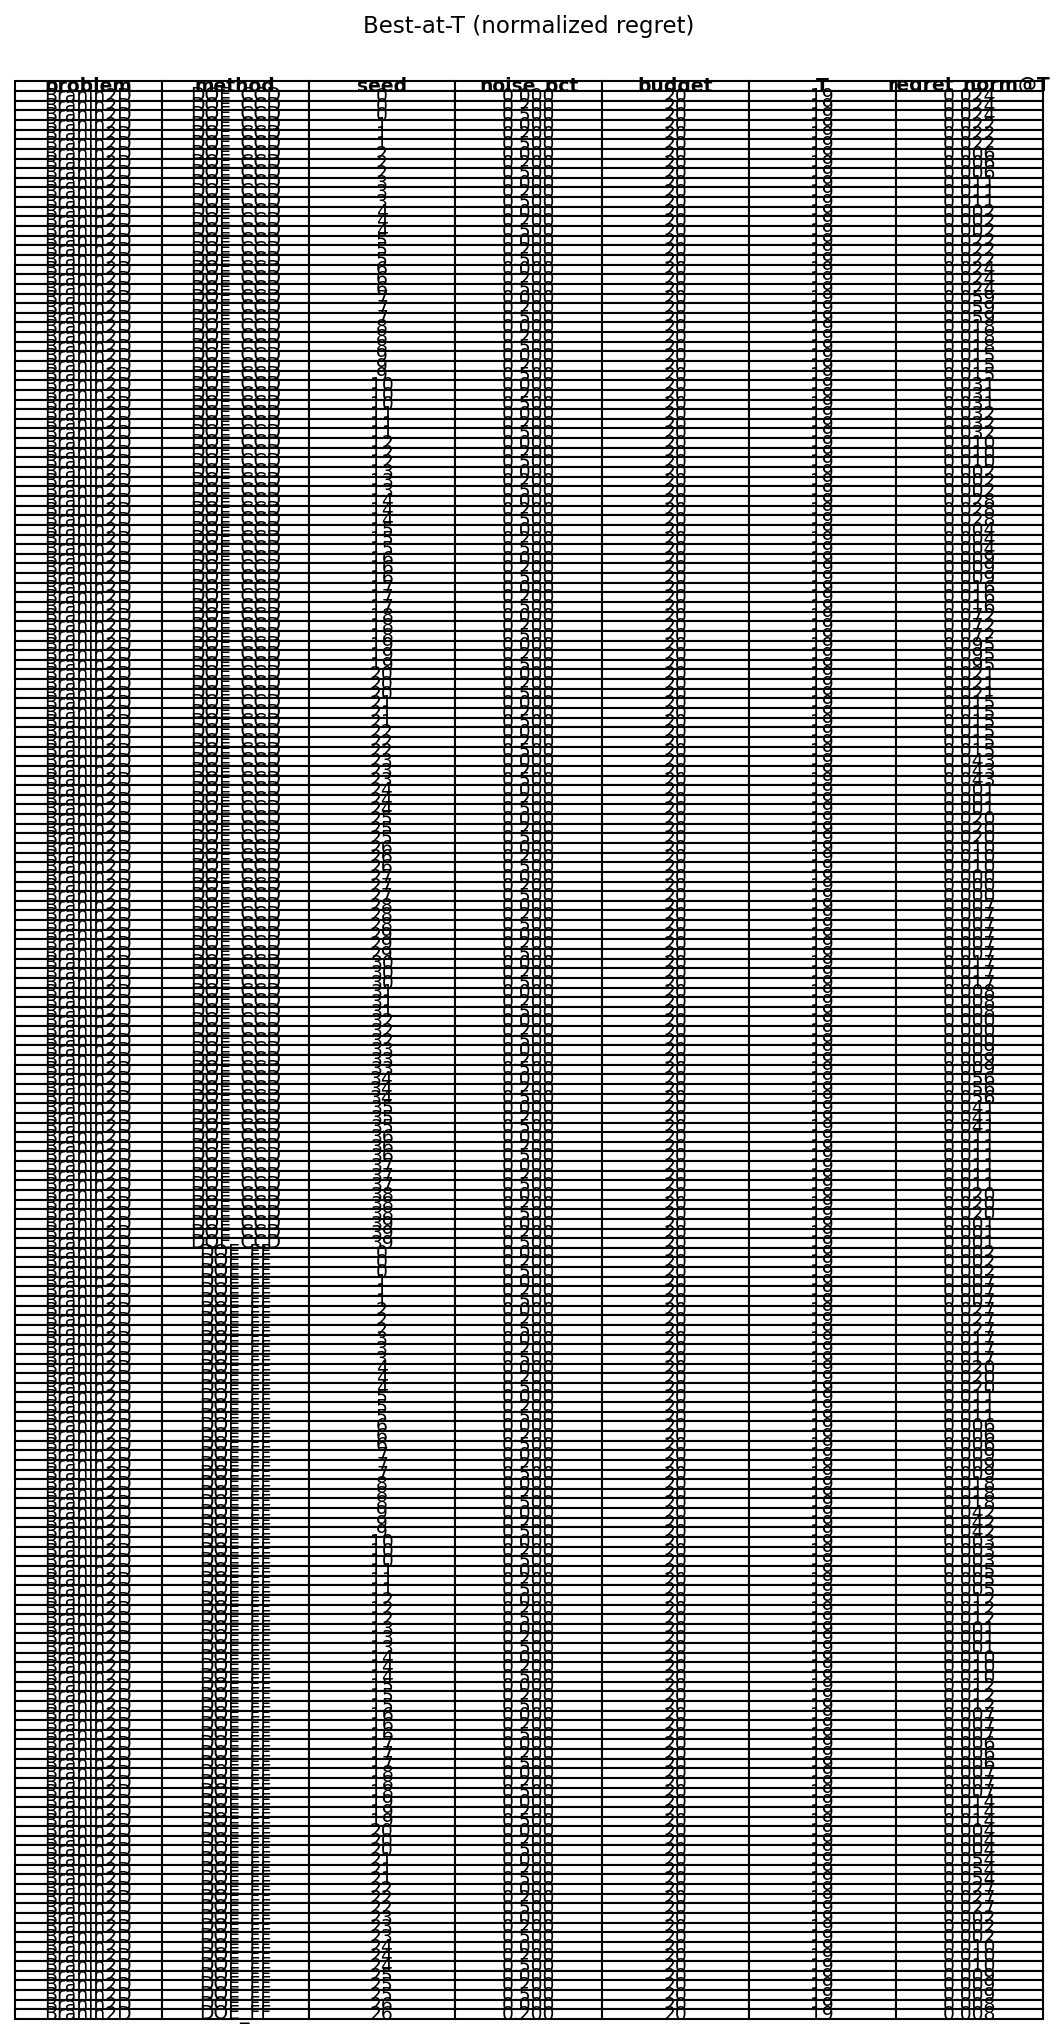

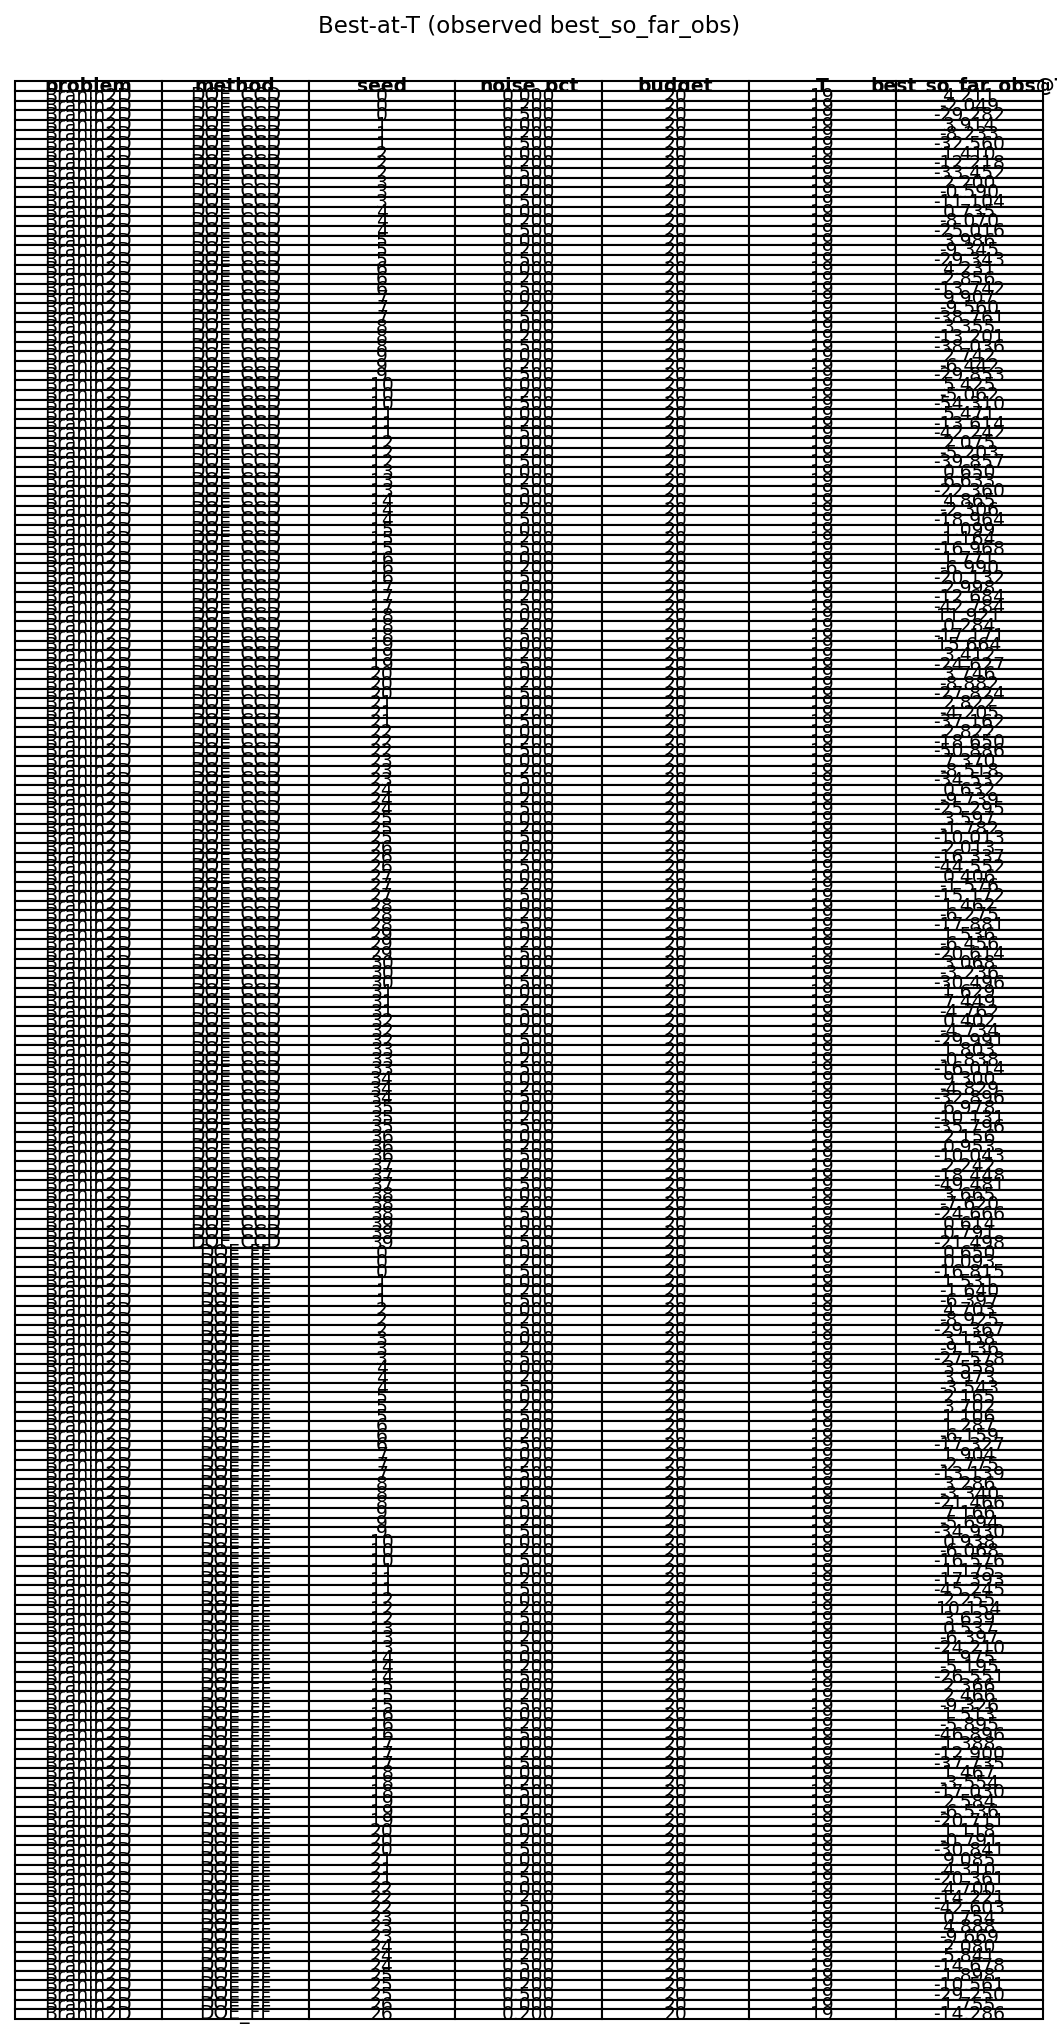

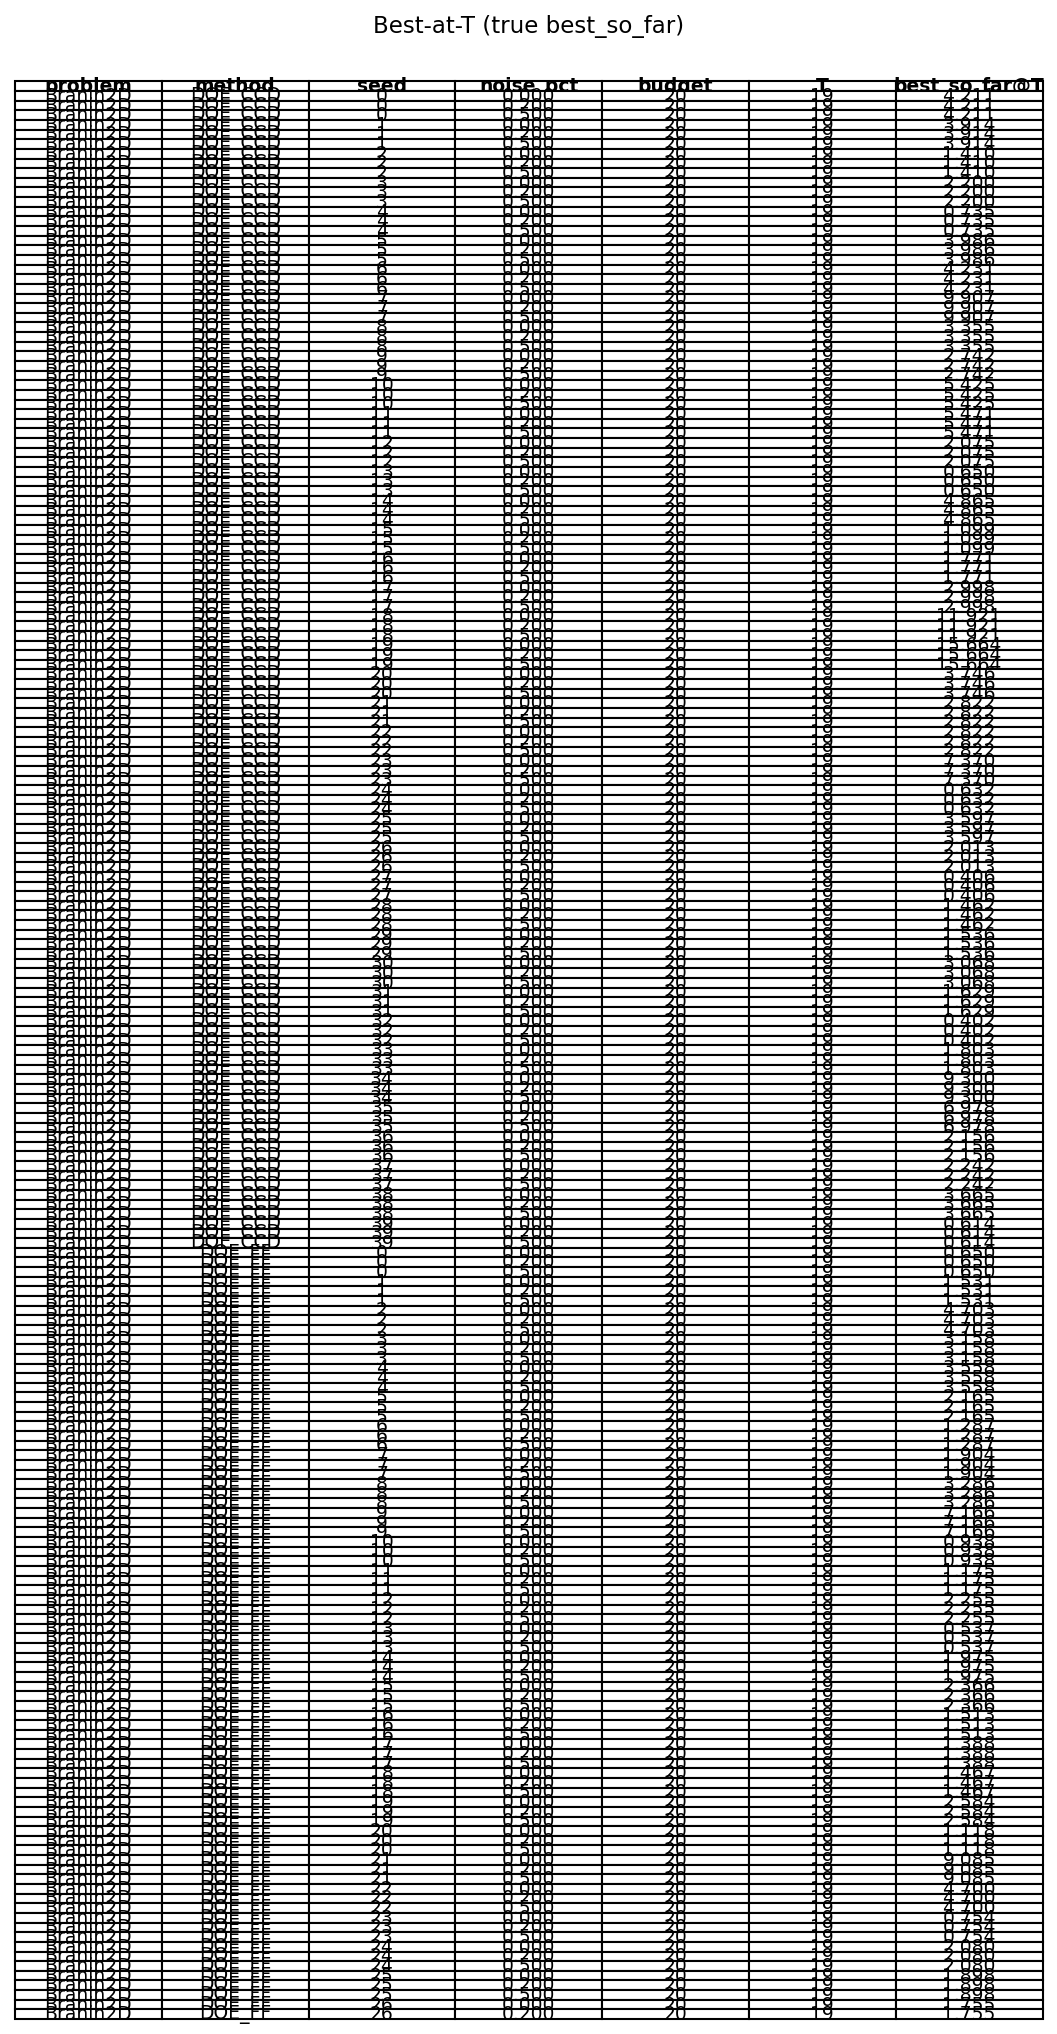

all_runs.csv shape: (7200, 21)


**Final rows per run (for boxplots):**

exp_name   problem   method  dim  seed  noise_seed  noise_pct  \
19    SB1_DOE_Head2Head  Branin2D  DOE_CCD    2     0      777000        0.0   
7179  SB1_DOE_Head2Head  Branin2D  DOE_LHS    2     9      777009        0.2   
39    SB1_DOE_Head2Head  Branin2D  DOE_CCD    2     0      777000        0.2   
59    SB1_DOE_Head2Head  Branin2D  DOE_CCD    2     0      777000        0.5   
79    SB1_DOE_Head2Head  Branin2D  DOE_CCD    2    10      777010        0.0   
99    SB1_DOE_Head2Head  Branin2D  DOE_CCD    2    10      777010        0.2   
119   SB1_DOE_Head2Head  Branin2D  DOE_CCD    2    10      777010        0.5   
139   SB1_DOE_Head2Head  Branin2D  DOE_CCD    2    11      777011        0.0   
6359  SB1_DOE_Head2Head  Branin2D  DOE_LHS    2    32      777032        0.5   
6479  SB1_DOE_Head2Head  Branin2D  DOE_LHS    2    34      777034        0.5   
6379  SB1_DOE_Head2Head  Branin2D  DOE_LHS    2    33      777033        0.0   
6399  SB1_DOE_Head2Head  Branin2D  DOE_LHS    2    33      777033        0.2   
6419  SB1_DOE_Head2Head  Branin2D  DOE_LHS    2    33      777033        0.5   
6439  SB1_DOE_Head2Head  Branin2D  DOE_LHS    2    34      777034        0.0   
6459  SB1_DOE_Head2Head  Branin2D  DOE_LHS    2    34      777034        0.2   
7199  SB1_DOE_Head2Head  Branin2D  DOE_LHS    2     9      777009        0.5   
3179  SB1_DOE_Head2Head  Branin2D   DOE_FF    2    20      777020        0.5   
6819  SB1_DOE_Head2Head  Branin2D  DOE_LHS    2     3      777003        0.2   
3199  SB1_DOE_Head2Head  Branin2D   DOE_FF    2    21      777021        0.0   
3219  SB1_DOE_Head2Head  Branin2D   DOE_FF    2    21      777021        0.2   

      sigma_noise  budget  iter  ...  \
19       0.000000      20    19  ...   
7179    10.289179      20    19  ...   
39      10.282938      20    19  ...   
59      25.707345      20    19  ...   
79       0.000000      20    19  ...   
99      10.172826      20    19  ...   
119     25.432064      20    19  ...   
139      0.000000      20    19  ...   
6359    25.790318      20    19  ...   
6479    25.303214      20    19  ...   
6379     0.000000      20    19  ...   
6399    10.065991      20    19  ...   
6419    25.164978      20    19  ...   
6439     0.000000      20    19  ...   
6459    10.121285      20    19  ...   
7199    25.722948      20    19  ...   
3179    25.750385      20    19  ...   
6819    10.103355      20    19  ...   
3199     0.000000      20    19  ...   
3219    10.104244      20    19  ...   

                                             x_uv  \
19         [0.06258606641554, 0.9847858316048543]   
7179       [0.746161910403511, 0.389230492633634]   
39         [0.06258606641554, 0.9847858316048543]   
59         [0.06258606641554, 0.9847858316048543]   
79      [0.12022495988782377, 0.6779108533356698]   
99      [0.12022495988782377, 0.6779108533356698]   
119     [0.12022495988782377, 0.6779108533356698]   
139   [0.011705424657077367, 0.09244338319068163]   
6359    [0.4205242650188329, 0.22298559198304016]   
6479     [0.9745313881794542, 0.8236611674517901]   
6379     [0.4401820978167758, 0.7904188955396515]   
6399     [0.4401820978167758, 0.7904188955396515]   
6419     [0.4401820978167758, 0.7904188955396515]   
6439     [0.9745313881794542, 0.8236611674517901]   
6459     [0.9745313881794542, 0.8236611674517901]   
7199       [0.746161910403511, 0.389230492633634]   
3179   [0.030075962630159214, 0.7111467098029421]   
6819     [0.6445855535222579, 0.9370878340034666]   
3199       [0.781117588817471, 0.855847029570968]   
3219       [0.781117588817471, 0.855847029570968]   

                                           x_xy  \
19    [-4.0612090037668995, 14.771787474072815]   
7179      [6.192428656052664, 5.83845738950451]   
39    [-4.0612090037668995, 14.771787474072815]   
59    [-4.0612090037668995, 14.771787474072815]   
79    [-3.1966256016826433, 10.168662800035047]   
99    [-3.1966256016826433, 10.168662800035047]   
119   [-3.196625601682

**Aggregate (true regret) for curves:**

problem   method  budget  noise_pct  iter     median        q25  \
0   Branin2D  DOE_CCD      20        0.0     0  23.382400  17.110312   
1   Branin2D  DOE_CCD      20        0.0     1  17.343978   6.896771   
2   Branin2D  DOE_CCD      20        0.0     2  16.031614   4.876482   
3   Branin2D  DOE_CCD      20        0.0     3  15.510180   4.112066   
4   Branin2D  DOE_CCD      20        0.0     4  14.568230   3.507791   
5   Branin2D  DOE_CCD      20        0.0     5   7.496639   2.649180   
6   Branin2D  DOE_CCD      20        0.0     6   7.437331   2.649180   
7   Branin2D  DOE_CCD      20        0.0     7   7.437331   2.649180   
8   Branin2D  DOE_CCD      20        0.0     8   7.321957   2.649180   
9   Branin2D  DOE_CCD      20        0.0     9   5.531820   2.404342   
10  Branin2D  DOE_CCD      20        0.0    10   3.552247   2.017557   
11  Branin2D  DOE_CCD      20        0.0    11   3.391645   1.755304   
12  Branin2D  DOE_CCD      20        0.0    12   3.233177   1.562352   
13  Branin2D  DOE_CCD      20        0.0    13   2.956264   1.562352   
14  Branin2D  DOE_CCD      20        0.0    14   2.956264   1.397080   
15  Branin2D  DOE_CCD      20        0.0    15   2.691831   1.397080   
16  Branin2D  DOE_CCD      20        0.0    16   2.691831   1.397080   
17  Branin2D  DOE_CCD      20        0.0    17   2.691831   1.397080   
18  Branin2D  DOE_CCD      20        0.0    18   2.547440   1.208088   
19  Branin2D  DOE_CCD      20        0.0    19   2.423974   1.208088   

          q75     n  
0   81.143946  40.0  
1   22.988363  40.0  
2   18.608974  40.0  
3   18.045199  40.0  
4   17.943601  40.0  
5   16.879759  40.0  
6   16.879759  40.0  
7   16.879759  40.0  
8   16.735968  40.0  
9   15.551082  40.0  
10   7.232235  40.0  
11   6.678334  40.0  
12   4.904594  40.0  
13   4.827258  40.0  
14   4.827258  40.0  
15   4.827258  40.0  
16   4.827258  40.0  
17   4.555314  40.0  
18   4.265806  40.0  
19   3.818354  40.0

**Aggregate (normalized regret) for curves:**

problem   method  iter    median       q25       q75  noise_pct
0   Branin2D  DOE_CCD     0  0.145829  0.106712  0.506072        0.0
1   Branin2D  DOE_CCD     1  0.108170  0.043013  0.143372        0.0
2   Branin2D  DOE_CCD     2  0.099985  0.030413  0.116059        0.0
3   Branin2D  DOE_CCD     3  0.096733  0.025646  0.112543        0.0
4   Branin2D  DOE_CCD     4  0.090858  0.021877  0.111909        0.0
5   Branin2D  DOE_CCD     5  0.046754  0.016522  0.105274        0.0
6   Branin2D  DOE_CCD     6  0.046385  0.016522  0.105274        0.0
7   Branin2D  DOE_CCD     7  0.046385  0.016522  0.105274        0.0
8   Branin2D  DOE_CCD     8  0.045665  0.016522  0.104378        0.0
9   Branin2D  DOE_CCD     9  0.034500  0.014995  0.096988        0.0
10  Branin2D  DOE_CCD    10  0.022154  0.012583  0.045105        0.0
11  Branin2D  DOE_CCD    11  0.021153  0.010947  0.041651        0.0
12  Branin2D  DOE_CCD    12  0.020164  0.009744  0.030589        0.0
13  Branin2D  DOE_CCD    13  0.018437  0.009744  0.030106        0.0
14  Branin2D  DOE_CCD    14  0.018437  0.008713  0.030106        0.0
15  Branin2D  DOE_CCD    15  0.016788  0.008713  0.030106        0.0
16  Branin2D  DOE_CCD    16  0.016788  0.008713  0.030106        0.0
17  Branin2D  DOE_CCD    17  0.016788  0.008713  0.028410        0.0
18  Branin2D  DOE_CCD    18  0.015888  0.007535  0.026605        0.0
19  Branin2D  DOE_CCD    19  0.015118  0.007535  0.023814        0.0

In [8]:
outdir = run_and_collect(main.EXP_NAME)
show_all_core_plots(outdir)
show_core_dataframes(outdir)

### Signifikanztest

In [19]:
# --- INLINE BOXPLOT: one method fixed, x-axis = noise levels -----------------
from pathlib import Path
from typing import Optional
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import evaluator as ev

def _apply_house_style_for_box(ax):
    """Use your project's boxplot style if available, else a close fallback."""
    # 1) try evaluator-internal helpers
    for name in ("_style_boxplot_ax", "_apply_boxplot_style", "_tb_style_ax"):
        if hasattr(ev, name):
            try:
                getattr(ev, name)(ax)
                return
            except Exception:
                pass
    # 2) try tb_style if present
    try:
        import tb_style  # your style module
        for cand in ("apply", "use", "set_mpl", "set_style"):
            if hasattr(tb_style, cand):
                try:
                    getattr(tb_style, cand)()
                    return
                except Exception:
                    pass
    except Exception:
        pass
    # 3) fallback: minimal house look
    ax.grid(True, axis="y", linestyle=":", alpha=0.4)
    for spine in ("top","right"):
        ax.spines[spine].set_visible(False)

def plot_box_by_noise_for_method_inline(
    outdir: Path,
    problem: str = "Branin2D",
    method: str = "DOE_LHS",
    metric: str = "true",   # "true" -> regret, "obs" -> regret_obs, "norm" -> regret_norm
    budget: Optional[int] = None,
    show_fliers: bool = False,
    decimals: int = 3,
):
    """Show a boxplot inline: x-axis = noise levels, one fixed method, metric at T. Also prints a summary table."""
    metric_map = {"true": "regret", "obs": "regret_obs", "norm": "regret_norm"}
    if metric not in metric_map:
        raise ValueError(f"metric must be one of {list(metric_map.keys())}")
    col = metric_map[metric]

    df = ev.load_logs(outdir)
    sub = df[(df["problem"] == problem) & (df["method"] == method)].copy()
    if sub.empty:
        raise ValueError(f"No data for problem={problem}, method={method}. "
                         f"If your logs use 'Branin' instead of 'Branin2D', try problem='Branin'.")

    # Fix budget T
    if "budget" in sub.columns and sub["budget"].notna().any():
        if budget is None:
            budget = int(sub["budget"].max())
        sub = sub[sub["budget"] == budget]
    else:
        # Fallback: infer T from last iter + 1
        budget = int(sub["iter"].max()) + 1

    # Final row per run at T
    keys = ["problem", "method", "seed", "budget"]
    if "noise_pct" in sub.columns:
        keys.append("noise_pct")
    final = sub.sort_values("iter").groupby(keys, as_index=False).tail(1)

    if "noise_pct" not in final.columns:
        final["noise_pct"] = 0.0

    # Prepare data per noise level
    noise_levels = sorted(final["noise_pct"].unique())
    data = [final[final["noise_pct"] == n][col].values for n in noise_levels]
    labels = [f"{int(round(100*n))}%" for n in noise_levels]
    n_seeds = final["seed"].nunique() if "seed" in final.columns else len(final)

    # --- PLOT (inline, not saved)
    fig, ax = plt.subplots(figsize=(8, 4.8))
    _apply_house_style_for_box(ax)

    bp = ax.boxplot(
        data,
        labels=labels,
        showfliers=show_fliers,
        patch_artist=True,
        widths=0.6
    )
    # Fallback styling, falls Style-Hooks nichts gemacht haben
    for box in bp["boxes"]:
        box.set_facecolor("#E6E8F2")
        box.set_edgecolor("#3C3F4A")
        box.set_linewidth(1.2)
    for med in bp["medians"]:
        med.set_color("#1F1F1F")
        med.set_linewidth(1.6)
    for whisk in bp["whiskers"]:
        whisk.set_color("#3C3F4A")
        whisk.set_linewidth(1.2)
    for cap in bp["caps"]:
        cap.set_color("#3C3F4A")
        cap.set_linewidth(1.2)

    ylab = {"regret": "Regret at T", "regret_obs": "Observed regret at T", "regret_norm": "Normalized regret at T"}[col]
    title = f"{problem} — {method} — {ylab} (N={n_seeds}), T={budget}"
    ax.set_title(title)
    ax.set_xlabel("Noise level α")
    ax.set_ylabel(ylab)

    plt.show()  # only display, do not save

    # --- Summary table inline
    summary = (
        final.groupby("noise_pct")[col]
        .agg(
            n="count",
            median="median",
            q25=lambda s: s.quantile(0.25),
            q75=lambda s: s.quantile(0.75),
            mean="mean",
            std="std",
            min="min",
            max="max",
        )
        .reset_index()
    )
    summary["alpha"] = summary["noise_pct"].map(lambda n: f"{int(round(100*n))}%")
    summary = summary[["alpha","n","median","q25","q75","mean","std","min","max"]].round(decimals)

    display(Markdown("**Per-noise summary:**"))
    display(summary)

    return summary


### Special Plot

In [25]:
# --- INLINE BOXPLOT: one fixed method, x-axis = noise levels (exact project style) ---
from pathlib import Path
from typing import Optional
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import evaluator as ev
import tb_style

def _value_col_from_metric(metric: str) -> str:
    m = metric.lower()
    if m in ("regret", "true"): return "regret"
    if m in ("regret_obs", "obs"): return "regret_obs"
    if m in ("regret_norm", "norm"): return "regret_norm"
    if m in ("best_so_far", "best"): return "best_so_far"
    if m in ("best_so_far_obs", "best_obs"): return "best_so_far_obs"
    raise ValueError("metric must be one of {'regret','regret_obs','regret_norm','best_so_far','best_so_far_obs'}")

def _ylabel_from_metric(metric: str) -> str:
    m = metric.lower()
    if m == "regret": return "Final regret @ T"
    if m == "regret_obs": return "Final observed regret @ T"
    if m == "regret_norm": return "Final normalized regret @ T"
    if m == "best_so_far": return "Final best value @ T"
    if m == "best_so_far_obs": return "Final observed best value @ T"
    return metric

def plot_box_by_noise_fixed_method_inline(
    outdir: Path,
    problem: str = "Branin2D",
    method: str = "DOE_FF",
    metric: str = "regret",               # 'regret'|'regret_obs'|'regret_norm'|'best_so_far'|'best_so_far_obs'
    budget: Optional[int] = None,
    highlight_seed: Optional[int] = 0,
    show_all_seeds: bool = True,
    jitter: float = 0.12,
    ypad: float = 0.05,
    y_min_override: Optional[float] = None,
    y_max_override: Optional[float] = None,
    decimals: int = 3,
):
    """Inline boxplot im evaluator/tb_style-Look: Methode fix, x-Achse = Noise-Level, Werte = final @ T."""
    tb_style.apply()  # exakt euren Style laden

    col = _value_col_from_metric(metric)
    ylabel = _ylabel_from_metric(metric)

    df = ev.load_logs(outdir)
    base = ev._final_rows_per_run(df)    # exakt wie eure Boxplots
    if base.empty:
        raise ValueError("No data after _final_rows_per_run().")

    if "noise_pct" not in base.columns:
        base = base.copy()
        base["noise_pct"] = 0.0

    sub = base[(base["problem"] == problem) & (base["method"] == method)].copy()
    if sub.empty:
        raise ValueError(f"No rows for problem={problem}, method={method}.")

    # Budget bestimmen/fixieren
    if "budget" in sub.columns and sub["budget"].notna().any():
        if budget is None:
            budget = int(sub["budget"].max())
        sub = sub[sub["budget"] == budget]
    else:
        budget = int(sub["iter"].max()) + 1

    if sub.empty:
        raise ValueError("No rows at the requested T (budget).")

    # Daten pro Noise-Level
    noise_levels = sorted(sub["noise_pct"].unique())
    labels = [f"{int(round(100*n))}%" for n in noise_levels]
    data   = [sub.loc[sub["noise_pct"] == n, col].to_numpy() for n in noise_levels]
    n_seeds = int(sub["seed"].nunique()) if "seed" in sub.columns else len(sub)

    # y-Limits über alle Noise-Level konsistent (wie lock_ylim_across_noise)
    if y_min_override is not None:
        y_min = float(y_min_override)
    else:
        y_min = 0.0 if col in ("regret","regret_obs","regret_norm") else float(np.nanmin([d.min() for d in data if len(d)]))

    if y_max_override is not None:
        y_max = float(y_max_override)
    else:
        ymax = np.nanmax([d.max() for d in data if len(d)])
        y_max = (1.0 if not np.isfinite(ymax) else ymax) * (1.0 + ypad)

    # Plot bauen (inline, nichts speichern)
    fig, ax = plt.subplots(figsize=(10, 6))
    bp = ax.boxplot(data, labels=labels, showfliers=False)

    # Punkte-Layer wie in euren Boxplots
    if show_all_seeds:
        for i, n in enumerate(noise_levels, start=1):
            vals = sub.loc[sub["noise_pct"] == n, col].to_numpy()
            if vals.size == 0:
                continue
            xs = i + (np.linspace(-jitter, jitter, vals.size) if vals.size > 1 else np.array([0.0]))
            ax.scatter(xs, vals, s=20, c="0.6", zorder=3, label=None)

    if highlight_seed is not None:
        hs = sub[sub["seed"] == int(highlight_seed)]
        for i, n in enumerate(noise_levels, start=1):
            vals = hs.loc[hs["noise_pct"] == n, col].to_numpy()
            if vals.size > 0:
                ax.scatter(np.repeat(i, vals.size), vals, s=36, c="black", zorder=4, label=None)

    # Legende wie üblich
    handles = []
    if show_all_seeds:
        handles.append(plt.Line2D([0], [0], marker='o', linestyle='None', markersize=6, color='0.6', label='All seeds'))
    if highlight_seed is not None:
        handles.append(plt.Line2D([0], [0], marker='o', linestyle='None', markersize=6, color='black', label=f'Seed {highlight_seed}'))
    if handles:
        ax.legend(handles=handles, loc="upper right")

    ax.set_ylim(y_min, y_max)
    ax.set_ylabel(ylabel)
    # Titel-Format wie bei euren Boxplots, aber ohne festes Noise im Titel:
    # "Branin2D — DOE_FF — Regret at T (N=40), T=20"
    main_title = f"{problem} — {method} — {ylabel.replace('Final ','').replace(' @ T',' at T')} (N={n_seeds}), T={budget}"
    ax.set_title(main_title)
    ax.set_xlabel("Noise level α")

    # Median-Annotationen (exakte Helper-Funktion aus evaluator)
    try:
        ev._annotate_median_labels_next_to_lines(ax, bp, data_len=len(noise_levels))
    except Exception:
        # falls Helper fehlt, leise ignorieren
        pass

    plt.show()

    # Troubleshooting-Tabelle inline
    summary = (
        sub.groupby("noise_pct")[col]
        .agg(
            n="count",
            median="median",
            q25=lambda s: s.quantile(0.25),
            q75=lambda s: s.quantile(0.75),
            mean="mean",
            std="std",
            min="min",
            max="max",
        )
        .reset_index()
    )
    summary["alpha"] = summary["noise_pct"].map(lambda n: f"{int(round(100*n))}%")
    summary = summary[["alpha","n","median","q25","q75","mean","std","min","max"]].round(decimals)
    display(Markdown("**Per-noise summary (final @ T):**"))
    display(summary)
    return summary


C:\Users\marti\AppData\Local\Temp\ipykernel_17748\48382960.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, showfliers=False)


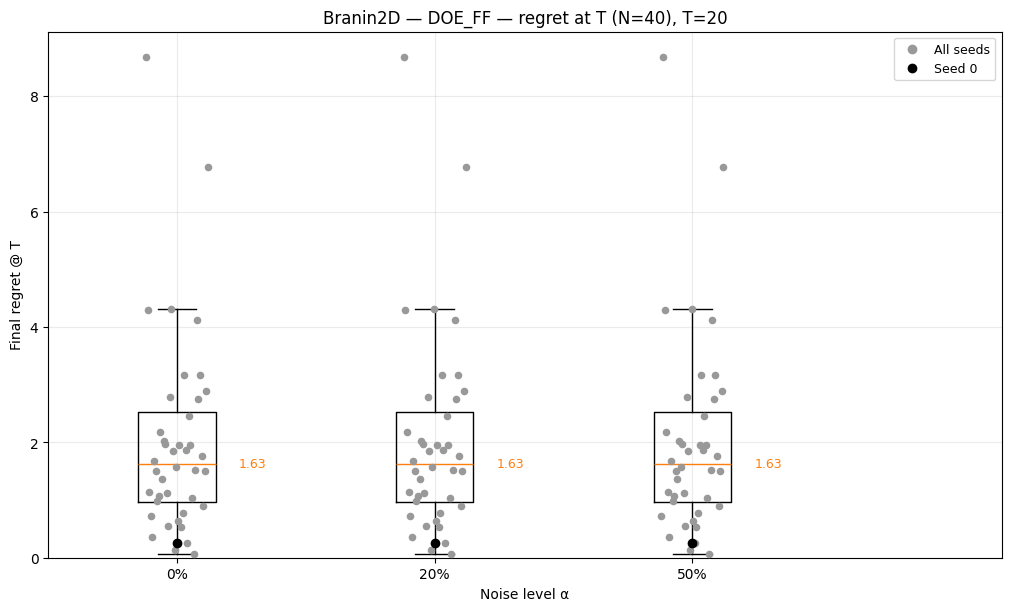

**Per-noise summary (final @ T):**

alpha   n  median    q25    q75  mean    std    min    max
0    0%  40    1.63  0.965  2.534  2.01  1.731  0.063  8.687
1   20%  40    1.63  0.965  2.534  2.01  1.731  0.063  8.687
2   50%  40    1.63  0.965  2.534  2.01  1.731  0.063  8.687

In [26]:
outdir = find_latest_results(main.EXP_NAME)

# a) Regret wie im linken Bild
_ = plot_box_by_noise_fixed_method_inline(
    outdir,
    problem="Branin2D",
    method="DOE_FF",
    metric="regret",   # alternativ: 'regret_obs' oder 'regret_norm'
    budget=20,
    show_all_seeds=True,
    highlight_seed=0
)

# # b) Best value @ T wie im rechten Beispielplot
# _ = plot_box_by_noise_fixed_method_inline(
#     outdir,
#     problem="Branin2D",
#     method="DOE_FF",
#     metric="best_so_far",  # oder 'best_so_far_obs'
#     budget=20
# )
